In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyarrow.parquet as pq   # For reading train_parquet file
import os
import numba 
from scipy.signal import find_peaks, argrelmax
import random
from tqdm.notebook import tqdm
from datetime import datetime

from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics

import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import GridSearchCV, StratifiedKFold  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from keras.layers import *
from keras.models import Model
from keras import backend as K  
from keras import optimizers  
from keras.callbacks import *  

from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential


Using TensorFlow backend.


In [2]:
start_time = datetime.now()

In [3]:
data_folder = '../../input/'
output_folder = '../output/'
os.listdir(data_folder)

['metadata_train.csv', 'train.parquet', 'VSB Power Line Fault Detection']

In [4]:
RECALCULATE_FEATURES = True
SAVE_FEATURES_FOR_FUTURE_USE = True
RECALCULATE_FEATURES_NON_RNN = True
SAVE_FEATURES_FOR_FUTURE_USE_NON_RNN = True

In [5]:
n_segments = 160    # number of segements per signal - For use in RNN
RANDOM_STATE = 55

In [6]:
"""
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

'\n%%javascript\nIPython.OutputArea.prototype._should_scroll = function(lines) {\n    return false;\n}\n'

In [7]:
df_meta = pd.read_csv(data_folder + 'metadata_train.csv')

In [8]:
%%time
# Load Parquet file containing 800k signal measurements for each signal_id in df_meta

parq_data = pq.read_pandas(data_folder + 'train.parquet').to_pandas()
SIGNAL_LENGTH = parq_data.shape[0]

Wall time: 16.2 s


## Understanding Data
* **Information on meta_data and signal_data**
* **Interpretation of data distribution**
* **Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals**  
* **Review peaks in sample signals**


### Information on meta_data and signal_data

In [9]:
df_meta.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [10]:
df_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [11]:
parq_data.shape

(800000, 8712)

In [12]:
col = [str(i) for i in range(5)]
parq_data[col].head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


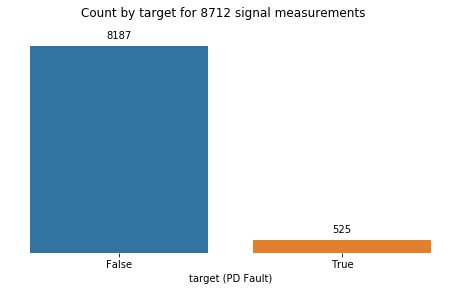

In [13]:
target = df_meta.target.copy()
plt.figure(figsize=(8, 4))
splot = sns.countplot(target.astype(bool))
for p in splot.patches:
    splot.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., 
                    p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

splot.spines['top'].set_visible(False)
splot.spines['right'].set_visible(False)
splot.spines['left'].set_visible(False)
splot.spines['bottom'].set_visible(False)
splot.set(yticks=[])
plt.ylabel(None)
plt.xlabel('target (PD Fault)')
plt.suptitle(f'Count by target for {len(target)} signal measurements')
plt.show()

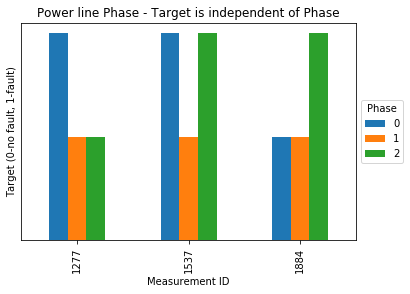

In [14]:
mids = [1277, 1537, 1884]
sample = df_meta.loc[df_meta.id_measurement.isin(mids), ["id_measurement", "phase", "target"]].copy()
sample.target = sample.target + 1
ax = sample.pivot("id_measurement", "phase", "target").plot(kind='bar')
ax.set(ylabel = 'Target (0-no fault, 1-fault)', 
       xlabel = 'Measurement ID', title = 'Power line Phase - Target is independent of Phase', 
       yticks=[])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Phase")
plt.show()

In [15]:
df_meta.corr()

,signal_id,id_measurement,phase,target
signal_id,1.000000,1.000000,0.000325,-0.023992
id_measurement,1.000000,1.000000,0.000000,-0.023993
phase,0.000325,0.000000,1.000000,0.001772
target,-0.023992,-0.023993,0.001772,1.000000


### Interpretation of data 
Understanding from above set of information
* Signal data (parq_data) contains 3 phase signal measurements.
* Each signal_id has 800k measurements in parq_data.
* parq_data has 3 phase (0, 1, 2) signal measurements for each of id_measurement. 
* Above table and phase plot highlights that target (1- PD fault or 0- PD free) is independent of phase and id_measurement

In [16]:
# Fault and Fault free signal_ids for understanding of signal patterns

fault_sid = df_meta.loc[df_meta.target == 1, 'signal_id']
fault_free_sid = df_meta.loc[df_meta.target == 0, 'signal_id']
print(fault_sid.shape, fault_free_sid.shape)

(525,) (8187,)


In [17]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    Source : https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [18]:
@numba.jit(nopython=True)
def drop_missing(intersect,sample):
    """
    Find intersection of sorted numpy arrays
    
    Since intersect1d sort arrays each time, it's effectively inefficient.
    Here you have to sweep intersection and each sample together to build
    the new intersection, which can be done in linear time, maintaining order. 

    Source: https://stackoverflow.com/questions/46572308/intersection-of-sorted-numpy-arrays
    Creator: B. M.
    """
    i=j=k=0
    new_intersect=np.empty_like(intersect)
    while i< intersect.size and j < sample.size:
        if intersect[i]==sample[j]: # the 99% case
            new_intersect[k]=intersect[i]
            k+=1
            i+=1
            j+=1
        elif intersect[i]<sample[j]:
            i+=1
        else : 
            j+=1
    return new_intersect[:k]

In [19]:
@numba.jit(nopython=True)
def _local_maxima_1d_window_single_pass(x, w):
    
    midpoints = np.empty(x.shape[0] // 2, dtype=np.intp)
    left_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    right_edges = np.empty(x.shape[0] // 2, dtype=np.intp)
    m = 0  # Pointer to the end of valid area in allocated arrays

    i = 1  # Pointer to current sample, first one can't be maxima
    i_max = x.shape[0] - 1  # Last sample can't be maxima
    while i < i_max:
        # Test if previous sample is smaller
        if x[i - 1] < x[i]:
            i_ahead = i + 1  # Index to look ahead of current sample

            # Find next sample that is unequal to x[i]
            while i_ahead < i_max and x[i_ahead] == x[i]:
                i_ahead += 1
                    
            i_right = i_ahead - 1
            
            f = False
            i_window_end = i_right + w
            while i_ahead < i_max and i_ahead < i_window_end:
                if x[i_ahead] > x[i]:
                    f = True
                    break
                i_ahead += 1
                
            # Maxima is found if next unequal sample is smaller than x[i]
            if x[i_ahead] < x[i]:
                left_edges[m] = i
                right_edges[m] = i_right
                midpoints[m] = (left_edges[m] + right_edges[m]) // 2
                m += 1
                
            # Skip samples that can't be maximum
            i = i_ahead - 1
        i += 1

    # Keep only valid part of array memory.
    midpoints = midpoints[:m]
    left_edges = left_edges[:m]
    right_edges = right_edges[:m]
    
    return midpoints, left_edges, right_edges

@numba.jit(nopython=True)
def local_maxima_1d_window(x, w=1):
    """
    Find local maxima in a 1D array.
    This function finds all local maxima in a 1D array and returns the indices
    for their midpoints (rounded down for even plateau sizes).
    It is a modified version of scipy.signal._peak_finding_utils._local_maxima_1d
    to include the use of a window to define how many points on each side to use in
    the test for a point being a local maxima.
    Parameters
    ----------
    x : ndarray
        The array to search for local maxima.
    w : np.int
        How many points on each side to use for the comparison to be True
    Returns
    -------
    midpoints : ndarray
        Indices of midpoints of local maxima in `x`.
    Notes
    -----
    - Compared to `argrelmax` this function is significantly faster and can
      detect maxima that are more than one sample wide. However this comes at
      the cost of being only applicable to 1D arrays.
    """    
        
    fm, fl, fr = _local_maxima_1d_window_single_pass(x, w)
    bm, bl, br = _local_maxima_1d_window_single_pass(x[::-1], w)
    bm = np.abs(bm - x.shape[0] + 1)[::-1]
    bl = np.abs(bl - x.shape[0] + 1)[::-1]
    br = np.abs(br - x.shape[0] + 1)[::-1]

    m = drop_missing(fm, bm)

    return m

In [20]:
@numba.jit(nopython=True)
def plateau_detection(grad, threshold, plateau_length=5):
    """Detect the point when the gradient has reach a plateau"""
    
    count = 0
    loc = 0
    for i in range(grad.shape[0]):
        if grad[i] > threshold:
            count += 1
        
        if count == plateau_length:
            loc = i - plateau_length
            break
            
    return loc

In [21]:
def get_peaks(
    x, 
    window=25,
    visualise=False,
    visualise_color=None,
):
    """
    Find the peaks in a signal trace.
    Parameters
    ----------
    x : ndarray
        The array to search.
    window : np.int
        How many points on each side to use for the local maxima test
    Returns
    -------
    peaks_x : ndarray
        Indices of midpoints of peaks in `x`.
    peaks_y : ndarray
        Absolute heights of troughs in `x`.
    peaks_y : ndarray
        Absolute heights of peaks in `x`.
    x_hp : ndarray
        An absolute flattened version of `x`.
    """
    
    x_hp = x # flatiron(x, 100, 1)

    x_dn = np.abs(x_hp)
    
    peaks = local_maxima_1d_window(x_dn, window)
    
    heights = x_dn[peaks]
    
    ii = np.argsort(heights)[::-1]
    
    peaks = peaks[ii]
    heights = heights[ii]
    
    ky = heights
    kx = np.arange(1, heights.shape[0]+1)
    
    conv_length = 9

    grad = np.diff(ky, 1)/np.diff(kx, 1)
    grad = np.convolve(grad, np.ones(conv_length)/conv_length)#, mode='valid')
    grad = grad[conv_length-1:-conv_length+1]
    
    knee_x = plateau_detection(grad, -0.01, plateau_length=1000)
    knee_x -= conv_length//2
    
    if visualise:
        plt.plot(grad, color=visualise_color)
        plt.axvline(knee_x, ls="--", color=visualise_color)
    
    peaks_x = peaks[:knee_x]
    peaks_y = heights[:knee_x]
    
    ii = np.argsort(peaks_x)
    peaks_x = peaks_x[ii]
    peaks_y = peaks_y[ii]
    
    troughs = np.asarray([])
        
    return peaks_x.astype(np.int), troughs, peaks_y   #** astype 

In [22]:
# @numba.jit
def get_peaks_troughs(flat_signal, prominence=8, distance=51):
    """
    Return peaks and troughs of given flat_signals
    """
    (pks_idx, _) = find_peaks(flat_signal, prominence=prominence, distance=distance)
    (trough_idx, trough_p)  = find_peaks(flat_signal * -1, prominence=prominence, distance=distance)
    return pks_idx, trough_idx 


# 3 - Fast Fourier Transform denoising

#### A little bit of maths ...
The Fourier Transform of an 1D signal $x$ of length $n$ is the following : 

> ### $\mathscr{f}_j = \sum_{k=0}^{n-1} x_k e^{\frac{2\pi i}{n} jk} , ~~\forall j=0, ... , n-1$ 

The idea is to represent the signal in the complex space, It is roughly a sum of sinusoïdal functions. And there is one coefficient per frequency present in the signal.

The frequency takes the following values : 
- $f = \frac{1}{dn} [0, 1, \ldots ,   \frac{n}{2}-1,  -\frac{n}{2}, \ldots , -1] $  if $n$ is even
- $f =\frac{1}{dn}  [0, 1, \ldots,  \frac{n-1}{2}, -\frac{n-1}{2}, \ldots, -1] $   if $n$ is odd

#### Denoising algorithm
The denoising steps are the following :
- Apply the fft to the signal
- Compute the frequencies associated with each coefficient
- Keep only the coefficients which have a low enough frequency (in absolute)
- Compute the inverse fft

In [23]:
# Source : https://www.kaggle.com/theoviel/fast-fourier-transform-denoising
#@numba.jit 
def filter_signal(signal, threshold=1e8):
    fourier = np.fft.rfft(signal)
    frequencies = np.fft.rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return np.fft.irfft(fourier)

In [24]:
def plot_signals_n_peaks(sample, pks_idx, sub_plot_title=None, title=None, color='c'):
    """
    To plot sample signals and its peaks & troughs
    Sample                      : list of Sample signals measurements - 2D list
    pks_idx                     : peaks index list
    trough_idx                  : trough index list
    sub_plot_title              : list of title for for the sub plots
    title                       : Title of the plot
    """
    sz = len(sample)
    fig, axs = plt.subplots(sz,1, figsize=(12,sz*4))
    for i, ax in enumerate(axs) :
        ax.plot(sample[i], color=color, alpha=0.7)
        ax.scatter(pks_idx[i], sample[i][pks_idx[i]], color='red')
        #** ax.scatter(trough_idx[i], sample[i][trough_idx[i]], color='red')
        ax.set_title(sub_plot_title[i], fontsize=16)

    fig.suptitle(title, size=20, y=0.9)
    plt.show()

### Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals & Review peaks in sample signals

In [25]:
# Identify 3 sample signals measurements for plotting to understand patterns
# Flattern and find peaks of the sample (PD) Fault FREE signal measurements

sids = fault_free_sid.sample(2,random_state=RANDOM_STATE)   # Get random sample (PD)fault free signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns     # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals
denoised_sample, d_flat_sample = [], []
d_pks_idx, d_trough_idx = [], []

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    #** p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    p_idx, t_idx, _ = get_peaks(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)
    
    denoised_sample.append(filter_signal(sample[i], threshold=1.37e7))
    #** d_flat_sample.append(flatiron(denoised_sample[i].astype(np.float)))
    d_flat_sample.append(flatiron(sample[i].astype(np.float)))
    #** p_idx, t_idx = get_peaks_troughs(d_flat_sample[i])
    p_idx, t_idx, _ = get_peaks(d_flat_sample[i])
    d_pks_idx.append(p_idx)
    d_trough_idx.append(t_idx)


In [26]:
t_idx

array([], dtype=float64)

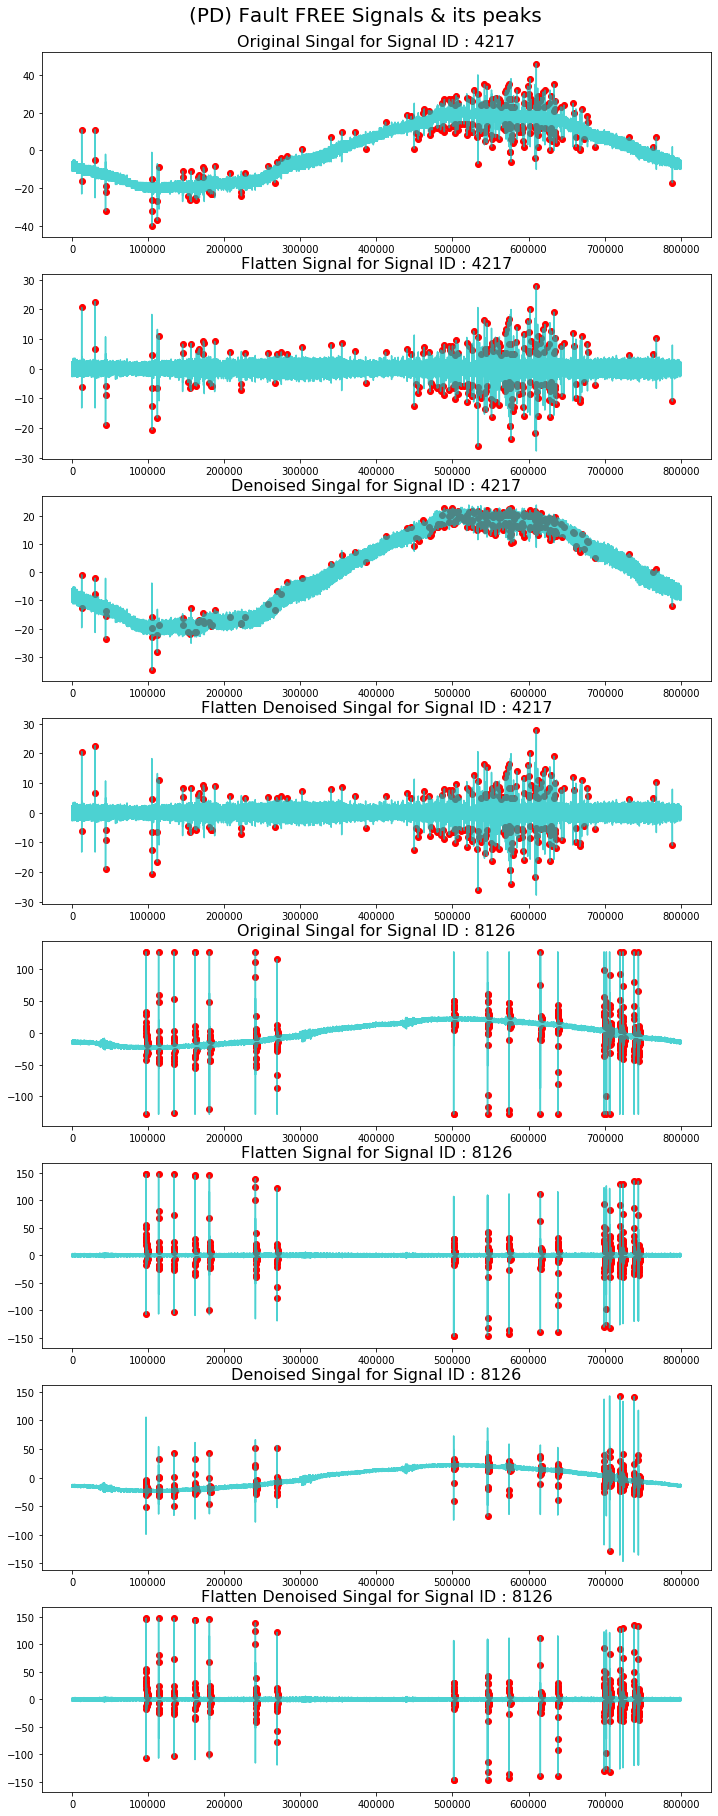

In [27]:
# Plot PD Fault FREE sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
t3 = ['Denoised Singal for Signal ID : ' + str(sid) for sid in sids]
t4 = ['Flatten Denoised Singal for Signal ID : ' + str(sid) for sid in sids]

sub_plot_title = [item for sublist in zip(t1,t2, t3, t4) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample, denoised_sample, d_flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx, d_pks_idx, d_pks_idx) for item in sublist]
#** c_trough_idx = [item for sublist in zip(trough_idx, trough_idx, d_trough_idx, d_trough_idx) for item in sublist]

#** plot_signals_n_peaks(c_sample, c_pks_idx, c_trough_idx, sub_plot_title, '(PD) Fault FREE Signals & its peaks')
plot_signals_n_peaks(c_sample, c_pks_idx, sub_plot_title, '(PD) Fault FREE Signals & its peaks') #**

In [28]:
# Identify 3 sample signals measurements for plotting to understanding patterns
# Flattern and find peaks of the sample (PD) FAULT signal measurements

sids = fault_sid.sample(2,random_state=RANDOM_STATE) # Get random sample (PD)fault signal_ids of measurements
sample_df = parq_data[map(str, sids)]             # assign measurement data of the samples

prominence, distance, cols = 6, 100, sample_df.columns     # Set values for flatten and find_peaks of signals 
sample, flat_sample, pks_idx, trough_idx = [], [], [], []  # initialize lists for flatten and peaks signals
denoised_sample, d_flat_sample = [], []
d_pks_idx, d_trough_idx = [], []

for i, col in enumerate(cols):
    sample.append(sample_df[col].values)
    flat_sample.append(flatiron(sample[i].astype(np.float)))
    #** p_idx, t_idx = get_peaks_troughs(flat_sample[i])
    p_idx, t_idx, _ = get_peaks(flat_sample[i])
    pks_idx.append(p_idx)
    trough_idx.append(t_idx)
    
    denoised_sample.append(filter_signal(sample[i], threshold=1e8))
    #** d_flat_sample.append(flatiron(denoised_sample[i].astype(np.float)))
    d_flat_sample.append(flatiron(sample[i].astype(np.float)))  #** 
    #** p_idx, t_idx = get_peaks_troughs(d_flat_sample[i])
    p_idx, t_idx, _ = get_peaks(d_flat_sample[i])
    d_pks_idx.append(p_idx)
    d_trough_idx.append(t_idx)


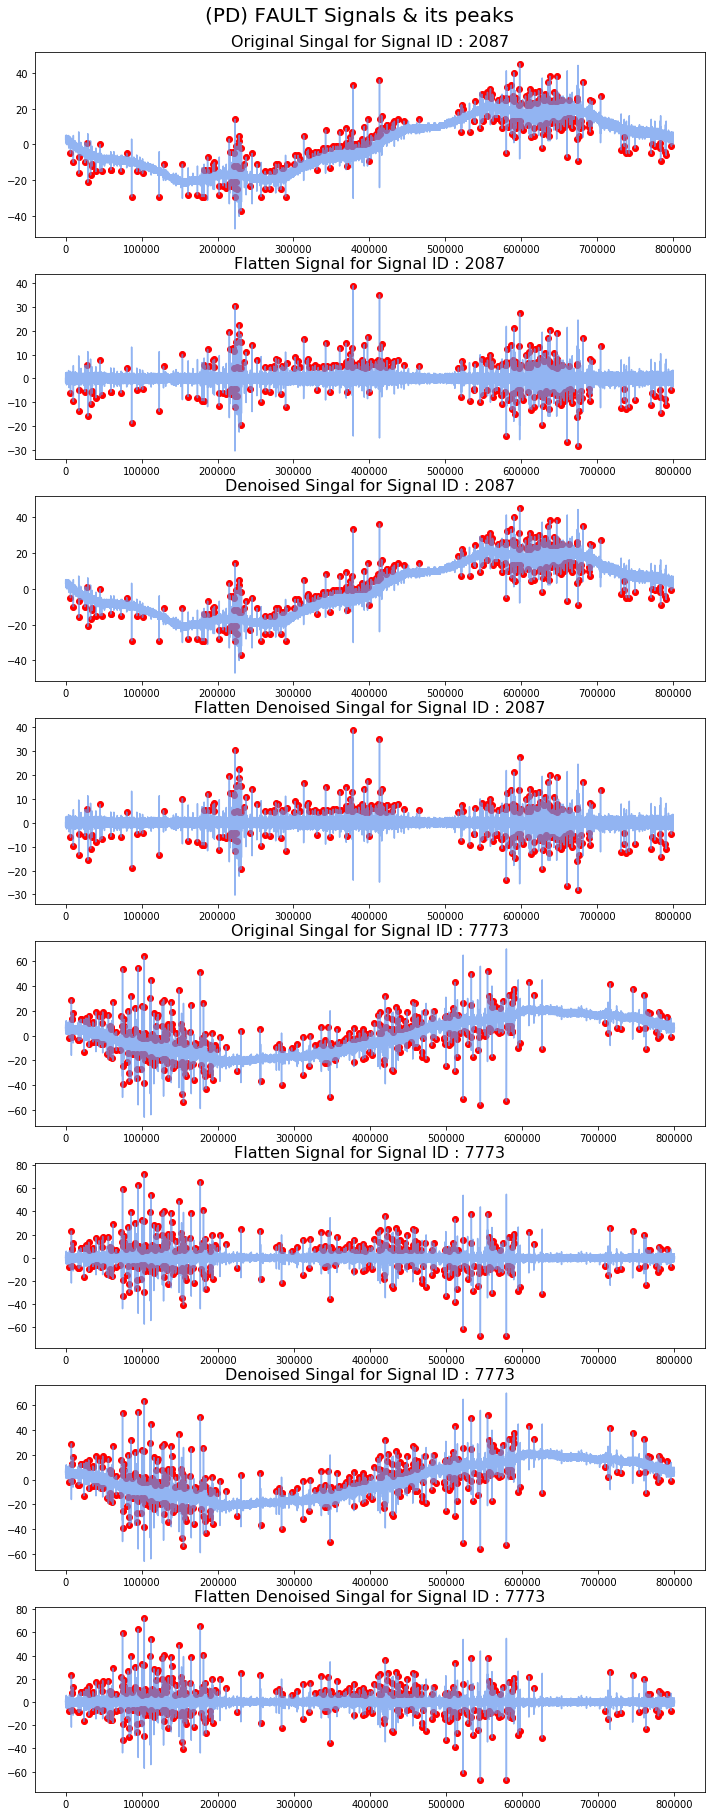

In [29]:
# Plot PD Fault sample signals

t1 = ['Original Singal for Signal ID : ' + str(sid) for sid in sids]
t2 = ['Flatten Signal for Signal ID : ' + str(sid) for sid in sids]
t3 = ['Denoised Singal for Signal ID : ' + str(sid) for sid in sids]
t4 = ['Flatten Denoised Singal for Signal ID : ' + str(sid) for sid in sids]

sub_plot_title = [item for sublist in zip(t1,t2, t3, t4) for item in sublist]

c_sample = [item for sublist in zip(sample, flat_sample, denoised_sample, d_flat_sample) for item in sublist]
c_pks_idx = [item for sublist in zip(pks_idx, pks_idx, d_pks_idx, d_pks_idx) for item in sublist]
c_trough_idx = [item for sublist in zip(trough_idx, trough_idx, d_trough_idx, d_trough_idx) for item in sublist]

plot_signals_n_peaks(c_sample, c_pks_idx, sub_plot_title, '(PD) FAULT Signals & its peaks', color='cornflowerblue')

In [30]:
@numba.jit(parallel=True)
def calculate_statistical_features (signal):
    """
    Find statistical features - mean, median, standard deviation, rms, n5, n25, n95
    for given denoised flatten signal
    """
    mean = np.nanmean(signal)
    median = np.nanpercentile(signal, 50)
    std = np.nanstd(signal)
    var = np.nanvar(signal)
    rms = np.nanmean(np.sqrt(signal**2))
    n5 = np.nanpercentile(signal, 5)
    n25 = np.nanpercentile(signal, 25)
    n75 = np.nanpercentile(signal, 75)
    n95 = np.nanpercentile(signal, 95)
        
    return [mean, median, std, rms, n5, n25, n95]

In [31]:
%xmode 

Exception reporting mode: Verbose


In [32]:
#** @numba.jit #** (nopython=True)
def clip(v, l, u):
    """Numba helper function to clip a value"""
    
    if v < l:
        v = l
    elif v > u:
        v = u
        
    return v

#** @numba.jit #** (nopython=True)
def create_sawtooth_template(sawtooth_length, pre_length, post_length):
    """Generate sawtooth template"""
    
    l = pre_length+post_length+1
    
    st = np.zeros(l)
    for i in range(sawtooth_length+1):
        
        j = pre_length+i
        if j < l:
            st[j] = 1 - ((2./sawtooth_length) * i)
        
    return st

#** @numba.jit #** (nopython=True)
def calculate_peak_features(pks_idx, x_signal0, window_small=5, window_large=25):
    """
    Calculate features for peaks.
    Parameters
    ----------
    pks_idx : ndarray
        Indices of peaks.
    x_signal0 : ndarray
        The array to search.
    window_small : np.int
        How many points on each side to use for small window features
    window_large : np.int
        How many points on each side to use for large window features
    Returns
    -------
    features : ndarray
        Features calculate for each peak in `x_signal0`.
    """
    
    peak_features_names = [
    'ratio_next',
    'ratio_prev',
    'small_dist_to_min',
    'sawtooth_rmse',
    ] 
    
    num_peak_features = len(peak_features_names)

    features = np.ones((pks_idx.shape[0], num_peak_features), dtype=np.float64) * np.nan
    
    for i in range(pks_idx.shape[0]):
        
        feature_number = 0
        
        x = pks_idx[i]
        x_next = x+1
        x_prev = x-1
        
        signal0 = x_signal0[x]

        window_small_start = clip(x-window_small, 0, 800000-1)
        window_small_end = clip(x+window_small, 0, 800000-1)
        window_large_start = clip(x-window_large, 0, 800000-1)
        window_large_end = clip(x+window_large, 0, 800000-1)
        
        window_small_pre = x - window_small_start
        window_small_post = window_small_end - x
        
        window_large_pre = x - window_large_start
        window_large_post = window_large_end - x
            
        if x_next < 800000:
            signal0_next = x_signal0[x_next]
            features[i, feature_number] = np.abs(signal0_next)/np.abs(signal0)
        feature_number += 1
            
        if x_prev >= 0:
            signal0_prev = x_signal0[x_prev]
            features[i, feature_number] = np.abs(signal0_prev)/np.abs(signal0)
        feature_number += 1
            
        x_hp_window_small0 = x_signal0[window_small_start:window_small_end+1]
        x_hp_window_large0 = x_signal0[window_large_start:window_large_end+1]
        x_hp_window_large0_norm = (x_hp_window_large0/np.abs(signal0))
        x_hp_window_small0_norm = (x_hp_window_small0/np.abs(signal0))
        x_hp_abs_window_large0 = np.abs(x_hp_window_large0)
        window_large_max_0 = np.max(x_hp_abs_window_large0)
        
        window_small_opp_peak_i = np.argmin(x_hp_window_small0*np.sign(signal0))
        
        features[i, feature_number] = window_small_opp_peak_i - window_small
        feature_number += 1
        
        x_hp_window_large0_norm_sign = x_hp_window_large0_norm * np.sign(signal0)
            
        sawtooth_length = 3
        saw_tooth_template = create_sawtooth_template(sawtooth_length, window_large_pre, window_large_post)
        
        """
        print ('st ', i,  st, x_hp_window_large0_norm_sign)
        print ('np.argmax(st) ', np.argmax(st))
        print ('np.argmax(x_hp_window_large0_norm_sign) ', np.argmax(x_hp_window_large0_norm_sign))
        """
        
        # assert np.argmax(st) == np.argmax(x_hp_window_large0_norm_sign)  #==> Check this as multiple peaks found in window
        
        assert saw_tooth_template.shape[0] == x_hp_window_large0_norm_sign.shape[0]
        features[i, feature_number] = np.mean(np.power(x_hp_window_large0_norm_sign - saw_tooth_template, 2))
        feature_number += 1
        
        if i == 0:
            assert feature_number == num_peak_features
        
    return features, peak_features_names

In [33]:
def calculate_fft_features(signal, peak_idx):
    nbr = 800000
    
    feature_number = 0
    peak_fft_features_names = [
        'phase_50hz',
        'phase_aligned_x',
        'Quadrant',        
    ] 
    assert signal.shape[0] == nbr
    num_peak_features = len(peak_fft_features_names)
    features = np.ones((len(peak_idx), num_peak_features), dtype=np.float64) * np.nan
   
    """
    Calculate the 50Hz Fourier coefficient of a signal.
    Assumes the signal is 800000 data points long and covering 20ms.
    """
    omegas = np.exp(-2j * np.pi * np.arange(nbr) / nbr).reshape(nbr, 1)
    omegas_ = omegas ** np.arange(1, 2)
    
    omegas_flat = omegas_.flatten()
    fft_data = omegas_flat.dot(signal.astype(omegas_flat.dtype))
    phase_50hz = np.angle(fft_data, deg=False)
    features[:, feature_number]  = phase_50hz
    
    """
    Calculate the phase aligned to get the quadrant.
    """
    feature_number += 1
    
    dt = (20e-3/(800000))
    f1 = 50
    w1 = 2*np.pi*f1
    phase_aligned_x = (np.degrees((w1 * peak_idx *dt) + phase_50hz) + 90) % 360
    
    features[:, feature_number] = phase_aligned_x
    
    """
    Calculate the  quadrant.
    """
    feature_number += 1
    
    # Calculate the phase resolved quarter for each peak
    Quadrant = pd.cut(phase_aligned_x , [0, 90, 180, 270, 360], labels=[0, 1, 2, 3])
    features[:, feature_number] = Quadrant
    return features, peak_fft_features_names

In [34]:
# @numba.jit(parallel=True)
def find_features(signal, signal_ids) :
    """
    Determine Features for the given denoised flat signal.
    Input :
        signal  :  Denoised flatten Signal
        signal_ids     :  Signal IDs of given given signal
    Returns :
        peaks_n_features : Returns a list containing features (including peaks, hiehgts and statistical features) 
                           determined for the given signal and combine it with signal_id
                           Returns a list for a shape of (signal.shape[0], flatten peaks_n_features)
        feature_names    : Feature column names corresponding to peaks_n_features    
    """
    length = len(signal)
    print(f'Processing for {length} signal measurements')
    features = np.ones((length, 7), dtype=np.float64) * np.nan  # 7 features
    pks_n_features = []
    
    feature_names = [
        'peaks_idx',
        'heights',
        'mean',
        'median',
        'std',
        'rms',
        'n5',
        'n25',
        'n95',
        'signal_id',
    ]
    denoise_threshold = 1.37e7

    for i in tqdm(numba.prange(length), desc='Finding Features:') : 

        #** denoised_signal = filter_signal(signal[i], threshold=denoise_threshold)
        #** flat_signal = flatiron(denoised_signal.astype(np.float))    # ==> flatten first before denoise
        flat_signal = flatiron(signal[i].astype(np.float))    # ==> flatten first before denoise
    
        # Get features : peaks indices (combined peaks+troughs) and their absolute heights
        #** pks_idx, troughs_idx = get_peaks_troughs(flat_signal)  #==> check this abs signal
        pks_idx, troughs_idx, ht = get_peaks(flat_signal) #**
        
        """
        print('pks_idx ', pks_idx)
        print('troughs_idx ', troughs_idx)
        """
        
        peaks_idx = np.concatenate((pks_idx, troughs_idx)).T  
        idx = np.argsort(peaks_idx)
        peaks_idx = peaks_idx[idx]
        #** heights = np.abs(flat_signal)[peaks_idx]
        heights = ht #**
        
        stats_features = np.ones((peaks_idx.shape[0], 8), dtype=np.float64) * np.nan
        mean, median, std, rms, n5, n25, n95 = calculate_statistical_features(flat_signal) 
        stats_features[:, 0] = mean
        stats_features[:, 1] = median
        stats_features[:, 2] = std
        stats_features[:, 3] = rms
        stats_features[:, 4] = n5
        stats_features[:, 5] = n25
        stats_features[:, 6] = n95
        stats_features[:, 7] = signal_ids[i]
        
        peaks_features, peak_features_names = calculate_peak_features(
            peaks_idx.astype(np.int),  #** astype
            flat_signal
        )
        
        peak_fft_features, peak_fft_feature_names = calculate_fft_features( flat_signal, peaks_idx)
        
        pks_n_features.append(np.hstack([
            peaks_idx[:, np.newaxis],
            heights[:, np.newaxis],
            stats_features,
            peaks_features,
            peak_fft_features,            
        ]))
    
    return pks_n_features, feature_names + peak_features_names + peak_fft_feature_names


In [35]:
#** statistical features at segment level
def segment_the_peak_features(features, mids, n_segments):
    """
    Segment the features for each signal id to prepare data for Recurrent Neural Network model
    Input : 
        features   : Calculated peak features dataframe
        mids       : list of id_measurements of parq_data used for peak features
        n_segments : number of segments per signal measurements 
    Output : 
        results    : segmented features with index column of id_measurement and seg_id
        shape      : required 3 dimensional shape of segmented results
                     (x, y, z) : x-number of id_measurements, y-number of segments, z-number of features per segment
    """
    SEGMENT_LENGTH = SIGNAL_LENGTH // n_segments
    
    assert SEGMENT_LENGTH * n_segments == SIGNAL_LENGTH
    
    # Filter peaks using ratio_next and height features
    # Note: may not be all that important
    features = features.loc[~(
        (features['ratio_next'] > 0.33333)
        & (features['heights'] > 50)
    )]
    
    features['seg_id'] = features.peaks_idx // SEGMENT_LENGTH
    # features.set_index(['id_measurement', 'seg_id'], inplace=True)   # To improve merge performance

    print('Initializing segments..')
    
    mid_idx = np.asarray([[i] * n_segments for i in mids ]).flatten()
    seg_idx = np.asarray([i for i in range(n_segments)] * len(mids)).flatten()
    
    #print('mid_idx seg_idx ', mid_idx, seg_idx)
    results = np.hstack([mid_idx[:, np.newaxis], seg_idx[:, np.newaxis]])
    #print('results ', results)
    results = pd.DataFrame(results, columns=['id_measurement', 'seg_id'])
    results.set_index(['id_measurement', 'seg_id'], inplace=True)
    
    print ('Calculating peak_count_Quadrant02')
    # Count peaks in phase resolved quarters 0 and 2

    p = features.loc[features['Quadrant'].isin([0, 2])].copy()
    res = p.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['count'],
    })
    res.columns = ["peak_count_Quadrant02"]
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')    
    
    print ('Calculating statistical features for Quadrant 0 & 2')
    res = features.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['mean', 'std'],
        'n5' : ['mean'],
        'n25' : ['mean'],
        'n95' : ['mean'],
        'rms' :['mean'],
    })
    res.columns = ["_".join(f) + '_seg' for f in res.columns]
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')    
    
    print ('Calculating peak_count_Quadrant13')
    # Count peaks in phase resolved quarters 1 and 3
    p = features.loc[features['Quadrant'].isin([1, 3])].copy()
    res = p.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['count'],
    })
    res.columns = ['peak_count_Quadrant13']
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')  
    
    print('Calculating peak_count_Quadrant13')
    res = p.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['count'],
    })
    res.columns = ["peak_count_Quadrant13"]
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')
    
    """ #** 
    print('Calculating statistical features for Quadrant13')
    res = p.groupby(['id_measurement', 'seg_id']).agg(
    {
        'n5'  : ['mean'],
        'n25' : ['mean'],
        'n95' : ['mean'],
        'rms' : ['mean'],
    })
    res.columns = ["_".join(f) + '_Quadrant13' for f in res.columns]
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')   
    """
    
    print('Calculating peak_count_total')
    # Count total peaks for each signal & seg id
    res = features.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['count'],
    })
    res.columns = ["peak_count_total"]
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')

    print('Calculating set of additional features')
    # Calculate additional features using phase resolved quarters 0 and 2

    feature_quarters = [0, 2]

    p = features.loc[features['Quadrant'].isin(feature_quarters)].copy()

    p['abs_small_dist_to_min'] = np.abs(p['small_dist_to_min'])

    res = p.groupby(['id_measurement', 'seg_id']).agg(
    {
        'heights': ['mean', 'std'],
        'ratio_prev': ['mean'],
        'ratio_next': ['mean'],
        'abs_small_dist_to_min': ['mean'],        
        'sawtooth_rmse': ['mean'],
    })
    res.columns = ["_".join(col) + '_Quadrant02' for col in res.columns]     
    results = pd.merge(results, res, on=['id_measurement', 'seg_id'], how='left')
    
    shape = (len(mids), n_segments, results.shape[1])

    return results, shape

In [36]:
def populate_important_features(peaks_df, meta_df, use_improved=True):
    
    results = pd.DataFrame(index=meta_df['id_measurement'].unique())
    results.index.rename('id_measurement', inplace=True)
       
    # Filter peaks using ratio_next and height features
    # Note: may not be all that important
    peaks_df = peaks_df[~(
        (peaks_df['ratio_next'] > 0.33333)
        & (peaks_df['heights'] > 50)
    )]
      
    # Count peaks in phase resolved quarters 0 and 2
    p = peaks_df[peaks_df['Quadrant'].isin([0, 2])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'peaks_idx': ['count'],
         'n5' : ['mean'],
         'n25' : ['mean'],
         'n95' : ['mean'],
         'rms' :['mean'],
    })
    res.columns = ["_".join(f) + '_Quadrant02' for f in res.columns]
    results = pd.merge(results, res, on='id_measurement', how='left')
    

    
    # Count total peaks for each measurement id
    res = peaks_df.groupby('id_measurement').agg(
    {
        'peaks_idx': ['count'],
    })
    res.columns = ["peak_count_total"]
    results = pd.merge(results, res, on='id_measurement', how='left')

  
    # Count peaks in phase resolved quarters 1 and 3
    p = peaks_df[peaks_df['Quadrant'].isin([1, 3])].copy()
    res = p.groupby('id_measurement').agg(
    {
        'peaks_idx': ['count'],
         'n5' : ['mean'],
         'n25' : ['mean'],
         'n95' : ['mean'],
         'rms' :['mean'],
        
    })
    res.columns = ["_".join(f) + '_Quadrant13' for f in res.columns]
    results = pd.merge(results, res, on='id_measurement', how='left')
    
   
    # Calculate additional features using phase resolved quarters 0 and 2
    
    feature_quarters = [0, 2]
    
    p = peaks_df[peaks_df['Quadrant'].isin(feature_quarters)].copy()
    
    p['abs_small_dist_to_min'] = np.abs(p['small_dist_to_min'])
    
    res = p.groupby('id_measurement').agg(
    {
        
        'heights': ['mean', 'std'],
        'ratio_prev': ['mean'],
        'ratio_next': ['mean'],
        'abs_small_dist_to_min': ['mean'],        
        'sawtooth_rmse': ['mean'],

    })
    res.columns = ["_".join(f) + '_Quadrant02' for f in res.columns]     
    results = pd.merge(results, res, on='id_measurement', how='left')
    
    print("results ",results.shape)      
    
    return results

In [37]:
%%time

s_start, s_end = 0, 8712
signal_ids = df_meta.signal_id[s_start:s_end].values
if RECALCULATE_FEATURES :

    peaks_n_features, feature_names = find_features(
        parq_data.values.T[s_start:s_end], signal_ids)

    peaks_n_features = np.concatenate(peaks_n_features) # flatten before converting to pd.dataframe

    features = pd.DataFrame(peaks_n_features, columns=feature_names)
    
    # Merge id_measurement column with calculated peak features
    features = pd.merge(features, df_meta[['signal_id', 'id_measurement']], on='signal_id', how='left')
else :
    features = pd.read_csv(output_folder + 'calculated_peak_features.csv')


Processing for 8712 signal measurements



Wall time: 31min 27s


In [38]:
%%time
if SAVE_FEATURES_FOR_FUTURE_USE :
    print ('Saving peak features in CSV file for future use')
    features.to_csv(output_folder + 'calculated_peak_features.csv', index=True)
features.head()

Saving peak features in CSV file for future use
Wall time: 32.5 s


,peaks_idx,heights,mean,median,std,rms,n5,n25,n95,signal_id,ratio_next,ratio_prev,small_dist_to_min,sawtooth_rmse,phase_50hz,phase_aligned_x,Quadrant,id_measurement
0,24554.0,4.705156,-0.000009,0.001897,0.9982,0.784047,-1.602164,-0.663789,1.610437,0.0,0.272445,0.902694,-1.0,0.080285,2.136762,223.476723,2.0,0
1,26087.0,5.568916,-0.000009,0.001897,0.9982,0.784047,-1.602164,-0.663789,1.610437,0.0,0.254407,0.785581,-1.0,0.081591,2.136762,224.166573,2.0,0
2,31681.0,8.415760,-0.000009,0.001897,0.9982,0.784047,-1.602164,-0.663789,1.610437,0.0,0.068728,0.891094,-1.0,0.075479,2.136762,226.683873,2.0,0
3,36913.0,6.569330,-0.000009,0.001897,0.9982,0.784047,-1.602164,-0.663789,1.610437,0.0,0.667703,0.816569,-1.0,0.099316,2.136762,229.038273,2.0,0
4,46340.0,5.765833,-0.000009,0.001897,0.9982,0.784047,-1.602164,-0.663789,1.610437,0.0,0.898712,0.897689,1.0,0.100638,2.136762,233.280423,2.0,0


In [39]:
%%time
# Calculate summarized important features and Segment it for RNN

if RECALCULATE_FEATURES :
    mids = df_meta.loc[df_meta['signal_id'].isin(signal_ids), 'id_measurement'].unique()
    results, shape = segment_the_peak_features(features, mids, n_segments)
    
    target = (
        df_meta.groupby('id_measurement')['target'].sum().round(0).astype(np.int)
        != 0 
    ).astype(np.float)
    target = pd.DataFrame(target, columns=['target'])
    
    results = pd.merge(results, target[['target']], on='id_measurement', how='left')
    
else :
    results = pd.read_csv(output_folder + 'segmented_features.csv')
    shape = (results.id_measurement.unique().shape[0], n_segments, results.shape[1])

C:\Users\Mukund\.conda\envs\issmCA3VSB\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Initializing segments..
Calculating peak_count_Quadrant02
Calculating statistical features for Quadrant 0 & 2
Calculating peak_count_Quadrant13
Calculating peak_count_Quadrant13
Calculating peak_count_total
Calculating set of additional features
Wall time: 3.66 s


In [40]:
%%time

if SAVE_FEATURES_FOR_FUTURE_USE :
    print ('Saving important segmented features in CSV file for future use')
    results.to_csv(output_folder + 'segmented_features.csv', index=True)

Saving important segmented features in CSV file for future use
Wall time: 6.57 s


In [41]:
print('Segmented results shape ', results.shape)
results[~results.heights_mean_Quadrant02.isnull()].head()

Segmented results shape  (464640, 17)


,peak_count_Quadrant02,heights_mean_seg,heights_std_seg,n5_mean_seg,n25_mean_seg,n95_mean_seg,rms_mean_seg,peak_count_Quadrant13_x,peak_count_Quadrant13_y,peak_count_total,heights_mean_Quadrant02,heights_std_Quadrant02,ratio_prev_mean_Quadrant02,ratio_next_mean_Quadrant02,abs_small_dist_to_min_mean_Quadrant02,sawtooth_rmse_mean_Quadrant02,target
id_measurement,,,,,,,,,,,,,,,,,
0,1.0,5.186859,0.681231,-1.604667,-0.664988,1.584681,0.778036,1.0,1.0,2.0,4.705156,NaN,0.902694,0.272445,1.0,0.080285,0.0
0,1.0,5.568916,NaN,-1.602164,-0.663789,1.610437,0.784047,NaN,NaN,1.0,5.568916,NaN,0.785581,0.254407,1.0,0.081591,0.0
0,1.0,6.608177,2.556309,-1.604667,-0.664988,1.584681,0.778036,1.0,1.0,2.0,8.415760,NaN,0.891094,0.068728,1.0,0.075479,0.0
0,1.0,6.339631,0.324845,-1.604667,-0.664988,1.584681,0.778036,1.0,1.0,2.0,6.569330,NaN,0.816569,0.667703,1.0,0.099316,0.0
0,1.0,5.765833,NaN,-1.602164,-0.663789,1.610437,0.784047,NaN,NaN,1.0,5.765833,NaN,0.897689,0.898712,1.0,0.100638,0.0


In [42]:
%%time
# Calculate summarized important features for non-RNN models

if RECALCULATE_FEATURES_NON_RNN :
    # Calculate important features
    important_features = populate_important_features(features,df_meta[s_start:s_end]) #** 
    
    target = (
        df_meta.groupby('id_measurement')['target'].sum().round(0).astype(np.int)
        != 0
    ).astype(np.float)
    
    target = pd.DataFrame(target, columns=['target'])
    important_features = pd.merge(important_features, target[['target']], on='id_measurement', how='left')
    
else :
    important_features = pd.read_csv(output_folder + 'derived_features_target.csv')

if SAVE_FEATURES_FOR_FUTURE_USE_NON_RNN :
    # Save to CSV
    important_features.to_csv(output_folder + 'derived_features_target.csv', index=True)

results  (2904, 17)
Wall time: 930 ms


In [43]:
important_features.head()

,peaks_idx_count_Quadrant02,n5_mean_Quadrant02,n25_mean_Quadrant02,n95_mean_Quadrant02,rms_mean_Quadrant02,peak_count_total,peaks_idx_count_Quadrant13,n5_mean_Quadrant13,n25_mean_Quadrant13,n95_mean_Quadrant13,rms_mean_Quadrant13,heights_mean_Quadrant02,heights_std_Quadrant02,ratio_prev_mean_Quadrant02,ratio_next_mean_Quadrant02,abs_small_dist_to_min_mean_Quadrant02,sawtooth_rmse_mean_Quadrant02,target
id_measurement,,,,,,,,,,,,,,,,,,
0,271,-1.596174,-0.659582,1.588798,0.776835,436,165,-1.581346,-0.649797,1.574561,0.769181,7.983080,4.080501,0.424796,0.514141,1.468635,0.080991,0.0
1,340,-1.386085,-0.551815,1.369998,0.670829,588,248,-1.357613,-0.541930,1.340048,0.656969,9.490249,6.729119,0.471552,0.527007,1.505882,0.082910,1.0
2,56,-2.151651,-0.919952,2.150393,1.060984,108,52,-2.095261,-0.898644,2.093513,1.034456,10.010407,8.000431,0.306741,0.342301,2.267857,0.114437,0.0
3,355,-2.560254,-1.043100,2.555344,1.327088,681,326,-2.678056,-1.090626,2.674392,1.356389,13.344458,10.297633,0.465003,0.465384,2.256338,0.177119,0.0
4,241,-1.203687,-0.474672,1.192867,0.585568,470,229,-1.196896,-0.474770,1.187922,0.582965,9.013245,8.514853,0.435026,0.457522,2.199170,0.089538,0.0


## Model building and training

In [44]:
# below is the declaration of a function used inside the keras model, calculation with K (keras backend / thensorflow)
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

## RNN - LSTM 

In [45]:
# Load segmented features 
data = pd.read_csv(output_folder + 'segmented_features.csv')

# data.set_index(['id_measurement'], inplace=True)
print('Segmented feature data shape : ', data.shape)

Segmented feature data shape :  (464640, 18)


In [46]:
data.columns

Index(['id_measurement', 'peak_count_Quadrant02', 'heights_mean_seg',
       'heights_std_seg', 'n5_mean_seg', 'n25_mean_seg', 'n95_mean_seg',
       'rms_mean_seg', 'peak_count_Quadrant13_x', 'peak_count_Quadrant13_y',
       'peak_count_total', 'heights_mean_Quadrant02', 'heights_std_Quadrant02',
       'ratio_prev_mean_Quadrant02', 'ratio_next_mean_Quadrant02',
       'abs_small_dist_to_min_mean_Quadrant02',
       'sawtooth_rmse_mean_Quadrant02', 'target'],
      dtype='object')

In [47]:
# populate X and y from the loaded features
y = (
    data.groupby('id_measurement')['target'].sum().round(0).astype(np.int)
    != 0 
).astype(np.bool).to_numpy()

print('y.shape, type(y) : ', y.shape, type(y))
X = data.drop(['id_measurement', 'target'], axis=1)

# Columns to drop  #** 
cols_to_drop = ['peak_count_Quadrant02', 'peak_count_Quadrant13_x', 'peak_count_Quadrant13_y',
                'heights_mean_Quadrant02', 'heights_std_Quadrant02',
                'ratio_prev_mean_Quadrant02', 'ratio_next_mean_Quadrant02',
                'abs_small_dist_to_min_mean_Quadrant02',
                'sawtooth_rmse_mean_Quadrant02',]
X = data.drop(['id_measurement', 'target'] + cols_to_drop, axis=1)

# reshape in to 3 dimensional array of (id_measurement, n_segments, n_featues)
X = X.values.reshape(y.shape[0], n_segments, X.shape[1])

print('X.shape, type(X) : ', X.shape, type(X))


y.shape, type(y) :  (2904,) <class 'numpy.ndarray'>
X.shape, type(X) :  (2904, 160, 7) <class 'numpy.ndarray'>


In [48]:
# Split into train and test dataset 

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=1/4, random_state=RANDOM_STATE, stratify=y)

In [49]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [50]:
# This is NN LSTM Model creation
def define_lstm_model(input_shape):
    # The shape should be 3-dimensional
    inp = Input(shape=(input_shape[1], input_shape[2]))

    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    # addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    print (model.summary())
    
    return model

In [51]:
%%time
# Training LSTM model

N_SPLITS = 5
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(X_train, y_train))
preds_val = []
y_val = []
# Trining for each fold
for idx, (train_idx, val_idx) in tqdm(enumerate(splits)):
    K.clear_session() # clears the session
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = define_lstm_model(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, 
                           #monitor='val_roc_auc', mode='max')
                           monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt], verbose=True)
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape




Beginning fold 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 7)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160, 256)          140288    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 160, 128)          164864    
_________________________________________________________________
attention_1 (Attention)      (None, 128)               288       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 313,761
Tra

1742/1742 [==============================] - ETA: 0s - loss: 0.6520 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6506 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6501 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6503 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6502 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6499 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6504 - matthews_correlation: 0.0000e+ - 1s 435us/step - loss: 0.6502 - matthews_correlation: 0.0000e+00 - val_loss: 0.6478 - val_matthews_correlation: 0.0000e+00

Epoch 00008: val_matthews_correlation did not improve from 0.00000
Epoch 9/50
1742/1742 [==============================] - ETA: 0s - loss: 0.6446 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6468 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6447 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6452 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6448 - matthews_correlation: 0.0000e+ - ETA: 0s - los

1742/1742 [==============================] - ETA: 0s - loss: 0.5979 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5962 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5945 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5974 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5952 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5940 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5933 - matthews_correlation: 0.0000e+ - 1s 433us/step - loss: 0.5936 - matthews_correlation: 0.0000e+00 - val_loss: 0.5925 - val_matthews_correlation: 0.0000e+00

Epoch 00019: val_matthews_correlation did not improve from 0.00000
Epoch 20/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5811 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5888 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5885 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5876 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5882 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

Epoch 00028: val_matthews_correlation did not improve from 0.00000
Epoch 29/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5566 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5579 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5547 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5543 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5499 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5493 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5480 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5486 - matthews_correlation: 0.0000e+ - 1s 436us/step - loss: 0.5486 - matthews_correlation: 0.0000e+00 - val_loss: 0.5487 - val_matthews_correlation: 0.0000e+00

Epoch 00029: val_matthews_correlation did not improve from 0.00000
Epoch 30/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5616 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5533 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5507 - matthews_correlation: 0.

Epoch 00039: val_matthews_correlation did not improve from 0.00000
Epoch 40/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5076 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5100 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5055 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5091 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5106 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5078 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5051 - matthews_correlation: 0.0000e+ - 1s 432us/step - loss: 0.5055 - matthews_correlation: 0.0000e+00 - val_loss: 0.5068 - val_matthews_correlation: 0.0000e+00

Epoch 00040: val_matthews_correlation did not improve from 0.00000
Epoch 41/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5202 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5064 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5002 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5038 - matthews_correlation: 0.

1742/1742 [==============================] - ETA: 0s - loss: 0.4881 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4733 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4671 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4632 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4687 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4685 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4694 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4688 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4698 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4710 - matthews_correlation: 0.0000e+ - 1s 452us/step - loss: 0.4716 - matthews_correlation: 0.0000e+00 - val_loss: 0.4737 - val_matthews_correlation: 0.0000e+00

Epoch 00050: val_matthews_correlation did not improve from 0.00000
Beginning fold 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 


Epoch 00008: val_matthews_correlation did not improve from 0.00000
Epoch 9/50
1742/1742 [==============================] - ETA: 0s - loss: 0.6481 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6472 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6474 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6461 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6463 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6459 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6455 - matthews_correlation: 0.0000e+ - 1s 445us/step - loss: 0.6452 - matthews_correlation: 0.0000e+00 - val_loss: 0.6402 - val_matthews_correlation: 0.0000e+00

Epoch 00009: val_matthews_correlation did not improve from 0.00000
Epoch 10/50
1742/1742 [==============================] - ETA: 0s - loss: 0.6457 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6436 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6424 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6422 - matthews_correlation: 0.

1742/1742 [==============================] - ETA: 0s - loss: 0.6073 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5986 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5997 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5983 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5957 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5943 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5944 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5945 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5945 - matthews_correlation: 0.0000e+ - 1s 444us/step - loss: 0.5947 - matthews_correlation: 0.0000e+00 - val_loss: 0.5878 - val_matthews_correlation: 0.0000e+00

Epoch 00019: val_matthews_correlation did not improve from 0.00000
Epoch 20/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5871 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5868 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5897 - matthews_correlation: 0.0000e+ - ETA: 0s - lo


Epoch 00028: val_matthews_correlation did not improve from 0.00000
Epoch 29/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5508 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5573 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5606 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5566 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5554 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5558 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5529 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5514 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5508 - matthews_correlation: 0.0000e+ - 1s 447us/step - loss: 0.5503 - matthews_correlation: 0.0000e+00 - val_loss: 0.5417 - val_matthews_correlation: 0.0000e+00

Epoch 00029: val_matthews_correlation did not improve from 0.00000
Epoch 30/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5527 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5534 - matthews_correlation: 0

1742/1742 [==============================] - ETA: 0s - loss: 0.5191 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5098 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5100 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5116 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5133 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5122 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5134 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5129 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5125 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5132 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5122 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5116 - matthews_correlation: 0.0000e+ - 1s 457us/step - loss: 0.5116 - matthews_correlation: 0.0000e+00 - val_loss: 0.5012 - val_matthews_correlation: 0.0000e+00

Epoch 00039: val_matthews_correlation did not improve from 0.00000
Epoch 40/50
1742/1742 [==============================] - ETA: 0s - lo

Epoch 00048: val_matthews_correlation did not improve from 0.00000
Epoch 49/50
1742/1742 [==============================] - ETA: 0s - loss: 0.4770 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4840 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4802 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4772 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4756 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4756 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4764 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4771 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4786 - matthews_correlation: 0.0000e+ - 1s 447us/step - loss: 0.4778 - matthews_correlation: 0.0000e+00 - val_loss: 0.4657 - val_matthews_correlation: 0.0000e+00

Epoch 00049: val_matthews_correlation did not improve from 0.00000
Epoch 50/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5029 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4897 - matthews_correlation: 0.

Epoch 00006: val_matthews_correlation did not improve from 0.00000
Epoch 7/50
1742/1742 [==============================] - ETA: 0s - loss: 0.6569 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6561 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6571 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6570 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6571 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6565 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6565 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6563 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6560 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6558 - matthews_correlation: 0.0000e+ - 1s 449us/step - loss: 0.6557 - matthews_correlation: 0.0000e+00 - val_loss: 0.6530 - val_matthews_correlation: 0.0000e+00

Epoch 00007: val_matthews_correlation did not improve from 0.00000
Epoch 8/50
1742/1742 [==============================] - ETA: 0s - loss: 0.6534 - matthews_correlation: 0.00

1742/1742 [==============================] - ETA: 0s - loss: 0.6074 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6080 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6081 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6088 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6079 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6079 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6073 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6081 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6073 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6084 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6075 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6082 - matthews_correlation: 0.0000e+ - 1s 455us/step - loss: 0.6083 - matthews_correlation: 0.0000e+00 - val_loss: 0.6062 - val_matthews_correlation: 0.0000e+00

Epoch 00016: val_matthews_correlation did not improve from 0.00000
Epoch 17/50
1742/1742 [==============================] - ETA: 0s - lo

1742/1742 [==============================] - ETA: 0s - loss: 0.5606 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5579 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5628 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5620 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5660 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5650 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5663 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5660 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5664 - matthews_correlation: 0.0000e+ - 1s 447us/step - loss: 0.5661 - matthews_correlation: 0.0000e+00 - val_loss: 0.5647 - val_matthews_correlation: 0.0000e+00

Epoch 00025: val_matthews_correlation did not improve from 0.00000
Epoch 26/50
1742/1742 [==============================] - ETA: 0s - loss: 0.5663 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5651 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5672 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

1742/1742 [==============================] - ETA: 0s - loss: 0.5237 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5290 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5283 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5299 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5286 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5276 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5286 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5285 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5281 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5274 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5283 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5282 - matthews_correlation: 0.0000e+ - 1s 464us/step - loss: 0.5285 - matthews_correlation: 0.0000e+00 - val_loss: 0.5278 - val_matthews_correlation: 0.0000e+00

Epoch 00034: val_matthews_correlation did not improve from 0.00000
Epoch 35/50
1742/1742 [==============================] - ETA: 0s - lo


Epoch 00042: val_matthews_correlation did not improve from 0.00000
Epoch 43/50
1742/1742 [==============================] - ETA: 0s - loss: 0.4800 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4947 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5052 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5050 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4998 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4963 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4939 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4926 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4937 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4949 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4941 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4938 - matthews_correlation: 0.0000e+ - 1s 463us/step - loss: 0.4952 - matthews_correlation: 0.0000e+00 - val_loss: 0.4952 - val_matthews_correlation: 0.0000e+00

Epoch 00043: val_matthews_correlation did not improve fr

dense_2 (Dense)              (None, 1)                 65        
Total params: 313,761
Trainable params: 313,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 1743 samples, validate on 435 samples
Epoch 1/50
1743/1743 [==============================] - ETA: 13s - loss: 0.6931 - matthews_correlation: 0.0000e+0 - ETA: 6s - loss: 0.6929 - matthews_correlation: 0.0000e+0 - ETA: 4s - loss: 0.6927 - matthews_correlation: 0.0000e+ - ETA: 3s - loss: 0.6925 - matthews_correlation: 0.0000e+ - ETA: 2s - loss: 0.6923 - matthews_correlation: 0.0000e+ - ETA: 1s - loss: 0.6921 - matthews_correlation: 0.0000e+ - ETA: 1s - loss: 0.6918 - matthews_correlation: 0.0000e+ - ETA: 1s - loss: 0.6916 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6914 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6912 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6910 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6908 - matthews_correlation: 

1743/1743 [==============================] - ETA: 0s - loss: 0.6480 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6470 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6462 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6472 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6476 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6466 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6462 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6461 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6456 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6458 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6455 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6454 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6447 - matthews_correlation: 0.0000e+ - 1s 474us/step - loss: 0.6444 - matthews_correlation: 0.0000e+00 - val_loss: 0.6430 - val_matthews_correlation: 0.0000e+00

Epoch 00009: val_matthews_correlation did not improve from 0.00000
Epoch 10/50

1743/1743 [==============================] - ETA: 0s - loss: 0.6056 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6037 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6012 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6025 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6035 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6038 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6035 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6041 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6054 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6047 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6037 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6033 - matthews_correlation: 0.0000e+ - 1s 464us/step - loss: 0.6029 - matthews_correlation: 0.0000e+00 - val_loss: 0.6030 - val_matthews_correlation: 0.0000e+00

Epoch 00017: val_matthews_correlation did not improve from 0.00000
Epoch 18/50
1743/1743 [==============================] - ETA: 0s - lo

1743/1743 [==============================] - ETA: 0s - loss: 0.5630 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5591 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5670 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5679 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5651 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5656 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5660 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5654 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5641 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5641 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5650 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5652 - matthews_correlation: 0.0000e+ - 1s 460us/step - loss: 0.5654 - matthews_correlation: 0.0000e+00 - val_loss: 0.5670 - val_matthews_correlation: 0.0000e+00

Epoch 00025: val_matthews_correlation did not improve from 0.00000
Epoch 26/50
1743/1743 [==============================] - ETA: 0s - lo

1743/1743 [==============================] - ETA: 0s - loss: 0.5472 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5300 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5256 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5273 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5293 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5290 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5273 - matthews_correlation: 0.0000e+ - 1s 433us/step - loss: 0.5276 - matthews_correlation: 0.0000e+00 - val_loss: 0.5309 - val_matthews_correlation: 0.0000e+00

Epoch 00034: val_matthews_correlation did not improve from 0.00000
Epoch 35/50
1743/1743 [==============================] - ETA: 0s - loss: 0.5090 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5180 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5234 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5216 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5200 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

1743/1743 [==============================] - ETA: 0s - loss: 0.4988 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4853 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4859 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4820 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4830 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4840 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4868 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4871 - matthews_correlation: 0.0000e+ - 1s 438us/step - loss: 0.4873 - matthews_correlation: 0.0000e+00 - val_loss: 0.4924 - val_matthews_correlation: 0.0000e+00

Epoch 00045: val_matthews_correlation did not improve from 0.00000
Epoch 46/50
1743/1743 [==============================] - ETA: 0s - loss: 0.5091 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4893 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4870 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4865 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

1743/1743 [==============================] - ETA: 0s - loss: 0.6751 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6751 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6748 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6747 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6748 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6742 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6740 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6738 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6734 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6731 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6729 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6730 - matthews_correlation: 0.0000e+ - 1s 522us/step - loss: 0.6729 - matthews_correlation: 0.0000e+00 - val_loss: 0.6694 - val_matthews_correlation: 0.0000e+00

Epoch 00004: val_matthews_correlation did not improve from 0.00000
Epoch 5/50
1743/1743 [==============================] - ETA: 0s - los

1743/1743 [==============================] - ETA: 0s - loss: 0.6322 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6309 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6291 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6284 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6286 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6289 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6287 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6296 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6297 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6299 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6295 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6291 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.6290 - matthews_correlation: 0.0000e+ - 1s 507us/step - loss: 0.6289 - matthews_correlation: 0.0000e+00 - val_loss: 0.6252 - val_matthews_correlation: 0.0000e+00

Epoch 00012: val_matthews_correlation did not improve from 0.00000
Epoch 13/50

1743/1743 [==============================] - ETA: 0s - loss: 0.5911 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5899 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5867 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5856 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5900 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5889 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5898 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5889 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5895 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5890 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5889 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5893 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5896 - matthews_correlation: 0.0000e+ - 1s 489us/step - loss: 0.5894 - matthews_correlation: 0.0000e+00 - val_loss: 0.5854 - val_matthews_correlation: 0.0000e+00

Epoch 00020: val_matthews_correlation did not improve from 0.00000
Epoch 21/50

1743/1743 [==============================] - ETA: 0s - loss: 0.5522 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5632 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5595 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5594 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5581 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5571 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5573 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5556 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5545 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5550 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5543 - matthews_correlation: 0.0000e+ - 1s 460us/step - loss: 0.5536 - matthews_correlation: 0.0000e+00 - val_loss: 0.5494 - val_matthews_correlation: 0.0000e+00

Epoch 00028: val_matthews_correlation did not improve from 0.00000
Epoch 29/50
1743/1743 [==============================] - ETA: 0s - loss: 0.5450 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

1743/1743 [==============================] - ETA: 0s - loss: 0.5225 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5242 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5210 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5234 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5206 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5216 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5202 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5195 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5179 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5180 - matthews_correlation: 0.0000e+ - 1s 445us/step - loss: 0.5178 - matthews_correlation: 0.0000e+00 - val_loss: 0.5133 - val_matthews_correlation: 0.0000e+00

Epoch 00037: val_matthews_correlation did not improve from 0.00000
Epoch 38/50
1743/1743 [==============================] - ETA: 0s - loss: 0.5188 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.5135 - matthews_correlation: 0.0000e+ - ETA: 0s - lo

Epoch 00046: val_matthews_correlation did not improve from 0.00000
Epoch 47/50
1743/1743 [==============================] - ETA: 0s - loss: 0.5063 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4993 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4908 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4894 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4889 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4893 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4871 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4865 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4856 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4828 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.4830 - matthews_correlation: 0.0000e+ - 1s 453us/step - loss: 0.4827 - matthews_correlation: 0.0000e+00 - val_loss: 0.4780 - val_matthews_correlation: 0.0000e+00

Epoch 00047: val_matthews_correlation did not improve from 0.00000
Epoch 48/50
1743/1743 [=========================

((2178,), (2178,))

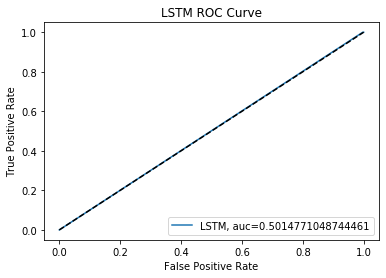

In [52]:
 
y_pred_proba = model.predict(X_test) 
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="LSTM, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('LSTM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## CNN

In [53]:
#Build the model
verbose, epochs, batch_size = True, 15, 16
n_steps, n_length, n_signals = X_train.shape[1], X_train.shape[2], 1
n_outputs = 1 # Binary
X_trainC = X_train.reshape((X_train.shape[0], n_steps, n_length, n_signals))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_signals)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_trainC, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Epoch 1/15
2178/2178 [==============================] - ETA: 2:57 - loss: 0.7358 - acc: 0.250 - ETA: 1:42 - loss: 0.7123 - acc: 0.593 - ETA: 1:16 - loss: 0.7036 - acc: 0.666 - ETA: 1:04 - loss: 0.6978 - acc: 0.718 - ETA: 56s - loss: 0.6927 - acc: 0.762 - ETA: 51s - loss: 0.6888 - acc: 0.78 - ETA: 47s - loss: 0.6843 - acc: 0.80 - ETA: 45s - loss: 0.6798 - acc: 0.82 - ETA: 43s - loss: 0.6750 - acc: 0.83 - ETA: 41s - loss: 0.6693 - acc: 0.85 - ETA: 39s - loss: 0.6627 - acc: 0.86 - ETA: 38s - loss: 0.6591 - acc: 0.85 - ETA: 37s - loss: 0.6516 - acc: 0.86 - ETA: 36s - loss: 0.6442 - acc: 0.86 - ETA: 35s - loss: 0.6313 - acc: 0.87 - ETA: 34s - loss: 0.6189 - acc: 0.87 - ETA: 33s - loss: 0.5990 - acc: 0.87 - ETA: 32s - loss: 0.5694 - acc: 0.88 - ETA: 31s - loss: 0.5682 - acc: 0.88 - ETA: 31s - loss: 0.5408 - acc: 0.88 - ETA: 30s - loss: 0.5158 - acc: 0.89 - ETA: 30s - loss: 0.50

2178/2178 [==============================] - ETA: 29s - loss: 0.0690 - acc: 1.00 - ETA: 30s - loss: 0.1530 - acc: 0.96 - ETA: 30s - loss: 0.1958 - acc: 0.95 - ETA: 29s - loss: 0.1624 - acc: 0.96 - ETA: 28s - loss: 0.1855 - acc: 0.96 - ETA: 28s - loss: 0.2246 - acc: 0.94 - ETA: 28s - loss: 0.2319 - acc: 0.94 - ETA: 28s - loss: 0.2099 - acc: 0.95 - ETA: 27s - loss: 0.2157 - acc: 0.95 - ETA: 27s - loss: 0.2220 - acc: 0.95 - ETA: 27s - loss: 0.2054 - acc: 0.95 - ETA: 27s - loss: 0.2092 - acc: 0.95 - ETA: 27s - loss: 0.1964 - acc: 0.95 - ETA: 26s - loss: 0.1857 - acc: 0.95 - ETA: 26s - loss: 0.1907 - acc: 0.95 - ETA: 26s - loss: 0.2092 - acc: 0.95 - ETA: 25s - loss: 0.2200 - acc: 0.94 - ETA: 25s - loss: 0.2227 - acc: 0.94 - ETA: 25s - loss: 0.2571 - acc: 0.93 - ETA: 25s - loss: 0.2553 - acc: 0.93 - ETA: 24s - loss: 0.2457 - acc: 0.94 - ETA: 24s - loss: 0.2450 - acc: 0.94 - ETA: 24s - loss: 0.2596 - acc: 0.93 - ETA: 24s - loss: 0.2578 - acc: 0.93 - ETA: 24s - loss: 0.2631 - acc: 0.93 - ETA: 

2178/2178 [==============================] - ETA: 27s - loss: 0.2556 - acc: 0.93 - ETA: 27s - loss: 0.2584 - acc: 0.93 - ETA: 28s - loss: 0.2515 - acc: 0.93 - ETA: 28s - loss: 0.2073 - acc: 0.95 - ETA: 27s - loss: 0.2372 - acc: 0.93 - ETA: 27s - loss: 0.2362 - acc: 0.93 - ETA: 26s - loss: 0.2329 - acc: 0.93 - ETA: 26s - loss: 0.2132 - acc: 0.94 - ETA: 26s - loss: 0.1965 - acc: 0.95 - ETA: 26s - loss: 0.1827 - acc: 0.95 - ETA: 26s - loss: 0.1719 - acc: 0.96 - ETA: 26s - loss: 0.1614 - acc: 0.96 - ETA: 25s - loss: 0.1669 - acc: 0.96 - ETA: 25s - loss: 0.1738 - acc: 0.95 - ETA: 25s - loss: 0.1891 - acc: 0.95 - ETA: 25s - loss: 0.1912 - acc: 0.95 - ETA: 24s - loss: 0.1821 - acc: 0.95 - ETA: 24s - loss: 0.1876 - acc: 0.95 - ETA: 24s - loss: 0.1921 - acc: 0.95 - ETA: 24s - loss: 0.1947 - acc: 0.95 - ETA: 23s - loss: 0.1972 - acc: 0.95 - ETA: 23s - loss: 0.2078 - acc: 0.94 - ETA: 23s - loss: 0.2002 - acc: 0.95 - ETA: 23s - loss: 0.2217 - acc: 0.94 - ETA: 22s - loss: 0.2144 - acc: 0.94 - ETA: 

2178/2178 [==============================] - ETA: 29s - loss: 0.0912 - acc: 1.00 - ETA: 28s - loss: 0.3152 - acc: 0.90 - ETA: 28s - loss: 0.2849 - acc: 0.91 - ETA: 27s - loss: 0.3931 - acc: 0.87 - ETA: 26s - loss: 0.3291 - acc: 0.90 - ETA: 26s - loss: 0.3648 - acc: 0.88 - ETA: 26s - loss: 0.3256 - acc: 0.90 - ETA: 26s - loss: 0.3528 - acc: 0.89 - ETA: 26s - loss: 0.3383 - acc: 0.89 - ETA: 26s - loss: 0.3426 - acc: 0.89 - ETA: 25s - loss: 0.3202 - acc: 0.90 - ETA: 25s - loss: 0.3013 - acc: 0.91 - ETA: 25s - loss: 0.2973 - acc: 0.91 - ETA: 25s - loss: 0.3471 - acc: 0.89 - ETA: 25s - loss: 0.3406 - acc: 0.89 - ETA: 24s - loss: 0.3269 - acc: 0.90 - ETA: 24s - loss: 0.3137 - acc: 0.90 - ETA: 24s - loss: 0.3080 - acc: 0.90 - ETA: 24s - loss: 0.3070 - acc: 0.91 - ETA: 24s - loss: 0.3120 - acc: 0.90 - ETA: 23s - loss: 0.3075 - acc: 0.91 - ETA: 23s - loss: 0.3128 - acc: 0.90 - ETA: 23s - loss: 0.3174 - acc: 0.90 - ETA: 23s - loss: 0.3082 - acc: 0.91 - ETA: 22s - loss: 0.3060 - acc: 0.91 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.4116 - acc: 0.87 - ETA: 28s - loss: 0.3440 - acc: 0.90 - ETA: 29s - loss: 0.3045 - acc: 0.91 - ETA: 28s - loss: 0.2899 - acc: 0.92 - ETA: 28s - loss: 0.3139 - acc: 0.91 - ETA: 27s - loss: 0.2838 - acc: 0.92 - ETA: 27s - loss: 0.2789 - acc: 0.92 - ETA: 27s - loss: 0.2594 - acc: 0.93 - ETA: 26s - loss: 0.2702 - acc: 0.93 - ETA: 26s - loss: 0.2676 - acc: 0.93 - ETA: 26s - loss: 0.2668 - acc: 0.93 - ETA: 26s - loss: 0.2632 - acc: 0.93 - ETA: 25s - loss: 0.2514 - acc: 0.93 - ETA: 25s - loss: 0.2399 - acc: 0.94 - ETA: 25s - loss: 0.2316 - acc: 0.94 - ETA: 24s - loss: 0.2404 - acc: 0.94 - ETA: 24s - loss: 0.2309 - acc: 0.94 - ETA: 24s - loss: 0.2393 - acc: 0.94 - ETA: 24s - loss: 0.2315 - acc: 0.94 - ETA: 23s - loss: 0.2238 - acc: 0.94 - ETA: 23s - loss: 0.2265 - acc: 0.94 - ETA: 23s - loss: 0.2271 - acc: 0.94 - ETA: 23s - loss: 0.2293 - acc: 0.94 - ETA: 23s - loss: 0.2399 - acc: 0.94 - ETA: 22s - loss: 0.2553 - acc: 0.93 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.4222 - acc: 0.87 - ETA: 26s - loss: 0.4615 - acc: 0.84 - ETA: 26s - loss: 0.3446 - acc: 0.89 - ETA: 26s - loss: 0.3195 - acc: 0.90 - ETA: 26s - loss: 0.2777 - acc: 0.92 - ETA: 26s - loss: 0.2969 - acc: 0.91 - ETA: 26s - loss: 0.3066 - acc: 0.91 - ETA: 25s - loss: 0.2965 - acc: 0.91 - ETA: 25s - loss: 0.3071 - acc: 0.90 - ETA: 25s - loss: 0.2989 - acc: 0.91 - ETA: 25s - loss: 0.2829 - acc: 0.92 - ETA: 25s - loss: 0.3050 - acc: 0.91 - ETA: 25s - loss: 0.3100 - acc: 0.90 - ETA: 24s - loss: 0.3250 - acc: 0.90 - ETA: 24s - loss: 0.3290 - acc: 0.90 - ETA: 24s - loss: 0.3157 - acc: 0.90 - ETA: 24s - loss: 0.3111 - acc: 0.90 - ETA: 23s - loss: 0.3171 - acc: 0.90 - ETA: 23s - loss: 0.3060 - acc: 0.91 - ETA: 23s - loss: 0.3108 - acc: 0.90 - ETA: 23s - loss: 0.3146 - acc: 0.90 - ETA: 23s - loss: 0.3116 - acc: 0.90 - ETA: 23s - loss: 0.3024 - acc: 0.91 - ETA: 22s - loss: 0.3000 - acc: 0.91 - ETA: 22s - loss: 0.2971 - acc: 0.91 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.0626 - acc: 1.00 - ETA: 26s - loss: 0.0628 - acc: 1.00 - ETA: 27s - loss: 0.1182 - acc: 0.97 - ETA: 27s - loss: 0.1503 - acc: 0.96 - ETA: 26s - loss: 0.1625 - acc: 0.96 - ETA: 26s - loss: 0.1423 - acc: 0.96 - ETA: 25s - loss: 0.1575 - acc: 0.96 - ETA: 25s - loss: 0.1953 - acc: 0.95 - ETA: 25s - loss: 0.1781 - acc: 0.95 - ETA: 25s - loss: 0.2203 - acc: 0.94 - ETA: 25s - loss: 0.2055 - acc: 0.94 - ETA: 24s - loss: 0.2238 - acc: 0.94 - ETA: 24s - loss: 0.2384 - acc: 0.93 - ETA: 24s - loss: 0.2378 - acc: 0.93 - ETA: 24s - loss: 0.2365 - acc: 0.93 - ETA: 24s - loss: 0.2364 - acc: 0.93 - ETA: 23s - loss: 0.2363 - acc: 0.93 - ETA: 23s - loss: 0.2372 - acc: 0.93 - ETA: 23s - loss: 0.2527 - acc: 0.93 - ETA: 23s - loss: 0.2599 - acc: 0.92 - ETA: 23s - loss: 0.2702 - acc: 0.92 - ETA: 22s - loss: 0.2683 - acc: 0.92 - ETA: 22s - loss: 0.2661 - acc: 0.92 - ETA: 22s - loss: 0.2652 - acc: 0.92 - ETA: 22s - loss: 0.2710 - acc: 0.92 - ETA: 

2178/2178 [==============================] - ETA: 28s - loss: 0.6540 - acc: 0.81 - ETA: 29s - loss: 0.5360 - acc: 0.84 - ETA: 29s - loss: 0.3754 - acc: 0.89 - ETA: 28s - loss: 0.2973 - acc: 0.92 - ETA: 28s - loss: 0.2909 - acc: 0.92 - ETA: 28s - loss: 0.2556 - acc: 0.93 - ETA: 27s - loss: 0.2541 - acc: 0.93 - ETA: 27s - loss: 0.2522 - acc: 0.93 - ETA: 26s - loss: 0.2503 - acc: 0.93 - ETA: 26s - loss: 0.2494 - acc: 0.93 - ETA: 26s - loss: 0.2338 - acc: 0.94 - ETA: 26s - loss: 0.2336 - acc: 0.94 - ETA: 26s - loss: 0.2326 - acc: 0.94 - ETA: 25s - loss: 0.2206 - acc: 0.94 - ETA: 25s - loss: 0.2103 - acc: 0.95 - ETA: 25s - loss: 0.2018 - acc: 0.95 - ETA: 25s - loss: 0.2154 - acc: 0.94 - ETA: 24s - loss: 0.2069 - acc: 0.95 - ETA: 24s - loss: 0.1992 - acc: 0.95 - ETA: 24s - loss: 0.2011 - acc: 0.95 - ETA: 23s - loss: 0.1941 - acc: 0.95 - ETA: 23s - loss: 0.1882 - acc: 0.95 - ETA: 23s - loss: 0.1825 - acc: 0.95 - ETA: 23s - loss: 0.1772 - acc: 0.96 - ETA: 22s - loss: 0.1780 - acc: 0.96 - ETA: 

2178/2178 [==============================] - ETA: 28s - loss: 0.3943 - acc: 0.87 - ETA: 28s - loss: 0.2441 - acc: 0.93 - ETA: 28s - loss: 0.2342 - acc: 0.93 - ETA: 27s - loss: 0.2374 - acc: 0.93 - ETA: 27s - loss: 0.2054 - acc: 0.95 - ETA: 27s - loss: 0.1841 - acc: 0.95 - ETA: 27s - loss: 0.1674 - acc: 0.96 - ETA: 26s - loss: 0.1548 - acc: 0.96 - ETA: 26s - loss: 0.1869 - acc: 0.95 - ETA: 26s - loss: 0.2071 - acc: 0.95 - ETA: 26s - loss: 0.1933 - acc: 0.95 - ETA: 25s - loss: 0.1935 - acc: 0.95 - ETA: 25s - loss: 0.2107 - acc: 0.94 - ETA: 25s - loss: 0.2002 - acc: 0.95 - ETA: 25s - loss: 0.1904 - acc: 0.95 - ETA: 25s - loss: 0.1923 - acc: 0.95 - ETA: 25s - loss: 0.1959 - acc: 0.95 - ETA: 24s - loss: 0.1988 - acc: 0.95 - ETA: 24s - loss: 0.2018 - acc: 0.95 - ETA: 24s - loss: 0.2157 - acc: 0.94 - ETA: 24s - loss: 0.2183 - acc: 0.94 - ETA: 24s - loss: 0.2207 - acc: 0.94 - ETA: 23s - loss: 0.2212 - acc: 0.94 - ETA: 23s - loss: 0.2230 - acc: 0.94 - ETA: 23s - loss: 0.2162 - acc: 0.94 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.2241 - acc: 0.93 - ETA: 27s - loss: 0.2200 - acc: 0.93 - ETA: 26s - loss: 0.1684 - acc: 0.95 - ETA: 26s - loss: 0.2303 - acc: 0.93 - ETA: 26s - loss: 0.1980 - acc: 0.95 - ETA: 26s - loss: 0.2383 - acc: 0.93 - ETA: 26s - loss: 0.2133 - acc: 0.94 - ETA: 26s - loss: 0.1929 - acc: 0.95 - ETA: 25s - loss: 0.1970 - acc: 0.95 - ETA: 25s - loss: 0.1830 - acc: 0.95 - ETA: 25s - loss: 0.1925 - acc: 0.95 - ETA: 25s - loss: 0.1973 - acc: 0.95 - ETA: 25s - loss: 0.1861 - acc: 0.95 - ETA: 25s - loss: 0.1875 - acc: 0.95 - ETA: 24s - loss: 0.1786 - acc: 0.95 - ETA: 24s - loss: 0.1966 - acc: 0.95 - ETA: 24s - loss: 0.2014 - acc: 0.95 - ETA: 24s - loss: 0.2149 - acc: 0.94 - ETA: 23s - loss: 0.2160 - acc: 0.94 - ETA: 23s - loss: 0.2333 - acc: 0.94 - ETA: 23s - loss: 0.2255 - acc: 0.94 - ETA: 23s - loss: 0.2279 - acc: 0.94 - ETA: 23s - loss: 0.2279 - acc: 0.94 - ETA: 23s - loss: 0.2207 - acc: 0.94 - ETA: 23s - loss: 0.2216 - acc: 0.94 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.5428 - acc: 0.81 - ETA: 26s - loss: 0.3924 - acc: 0.87 - ETA: 26s - loss: 0.3969 - acc: 0.87 - ETA: 26s - loss: 0.3229 - acc: 0.90 - ETA: 26s - loss: 0.3405 - acc: 0.90 - ETA: 26s - loss: 0.3691 - acc: 0.88 - ETA: 26s - loss: 0.3690 - acc: 0.88 - ETA: 25s - loss: 0.3494 - acc: 0.89 - ETA: 25s - loss: 0.3380 - acc: 0.89 - ETA: 25s - loss: 0.3283 - acc: 0.90 - ETA: 25s - loss: 0.3086 - acc: 0.90 - ETA: 25s - loss: 0.3145 - acc: 0.90 - ETA: 25s - loss: 0.3298 - acc: 0.89 - ETA: 24s - loss: 0.3146 - acc: 0.90 - ETA: 24s - loss: 0.3099 - acc: 0.90 - ETA: 24s - loss: 0.2969 - acc: 0.91 - ETA: 24s - loss: 0.2952 - acc: 0.91 - ETA: 24s - loss: 0.3098 - acc: 0.90 - ETA: 24s - loss: 0.3139 - acc: 0.90 - ETA: 23s - loss: 0.3187 - acc: 0.90 - ETA: 23s - loss: 0.3214 - acc: 0.90 - ETA: 23s - loss: 0.3234 - acc: 0.90 - ETA: 23s - loss: 0.3136 - acc: 0.90 - ETA: 23s - loss: 0.3117 - acc: 0.90 - ETA: 22s - loss: 0.3086 - acc: 0.91 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.2315 - acc: 0.93 - ETA: 29s - loss: 0.1492 - acc: 0.96 - ETA: 28s - loss: 0.1233 - acc: 0.97 - ETA: 28s - loss: 0.1471 - acc: 0.96 - ETA: 27s - loss: 0.1321 - acc: 0.97 - ETA: 27s - loss: 0.1569 - acc: 0.96 - ETA: 27s - loss: 0.1988 - acc: 0.95 - ETA: 27s - loss: 0.1811 - acc: 0.96 - ETA: 26s - loss: 0.1679 - acc: 0.96 - ETA: 26s - loss: 0.1749 - acc: 0.96 - ETA: 26s - loss: 0.1788 - acc: 0.96 - ETA: 25s - loss: 0.1819 - acc: 0.95 - ETA: 25s - loss: 0.2013 - acc: 0.95 - ETA: 25s - loss: 0.2160 - acc: 0.94 - ETA: 25s - loss: 0.2278 - acc: 0.94 - ETA: 24s - loss: 0.2177 - acc: 0.94 - ETA: 24s - loss: 0.2263 - acc: 0.94 - ETA: 24s - loss: 0.2283 - acc: 0.94 - ETA: 24s - loss: 0.2348 - acc: 0.93 - ETA: 23s - loss: 0.2269 - acc: 0.94 - ETA: 23s - loss: 0.2281 - acc: 0.94 - ETA: 23s - loss: 0.2208 - acc: 0.94 - ETA: 23s - loss: 0.2215 - acc: 0.94 - ETA: 22s - loss: 0.2208 - acc: 0.94 - ETA: 22s - loss: 0.2147 - acc: 0.94 - ETA: 

2178/2178 [==============================] - ETA: 26s - loss: 0.0804 - acc: 1.00 - ETA: 27s - loss: 0.0805 - acc: 1.00 - ETA: 26s - loss: 0.1744 - acc: 0.95 - ETA: 26s - loss: 0.2263 - acc: 0.93 - ETA: 26s - loss: 0.2000 - acc: 0.95 - ETA: 26s - loss: 0.2568 - acc: 0.92 - ETA: 26s - loss: 0.2777 - acc: 0.91 - ETA: 26s - loss: 0.2509 - acc: 0.92 - ETA: 25s - loss: 0.2487 - acc: 0.93 - ETA: 25s - loss: 0.2505 - acc: 0.93 - ETA: 25s - loss: 0.2479 - acc: 0.93 - ETA: 25s - loss: 0.2346 - acc: 0.93 - ETA: 25s - loss: 0.2363 - acc: 0.93 - ETA: 25s - loss: 0.2363 - acc: 0.93 - ETA: 24s - loss: 0.2364 - acc: 0.93 - ETA: 24s - loss: 0.2584 - acc: 0.92 - ETA: 24s - loss: 0.2578 - acc: 0.93 - ETA: 24s - loss: 0.2648 - acc: 0.92 - ETA: 24s - loss: 0.2552 - acc: 0.93 - ETA: 23s - loss: 0.2595 - acc: 0.92 - ETA: 23s - loss: 0.2572 - acc: 0.92 - ETA: 23s - loss: 0.2573 - acc: 0.92 - ETA: 23s - loss: 0.2502 - acc: 0.93 - ETA: 23s - loss: 0.2493 - acc: 0.93 - ETA: 22s - loss: 0.2472 - acc: 0.93 - ETA: 

2178/2178 [==============================] - ETA: 34s - loss: 0.0904 - acc: 1.00 - ETA: 36s - loss: 0.0892 - acc: 1.00 - ETA: 36s - loss: 0.0877 - acc: 1.00 - ETA: 34s - loss: 0.1292 - acc: 0.98 - ETA: 33s - loss: 0.1187 - acc: 0.98 - ETA: 32s - loss: 0.1361 - acc: 0.97 - ETA: 32s - loss: 0.2235 - acc: 0.94 - ETA: 31s - loss: 0.2052 - acc: 0.95 - ETA: 31s - loss: 0.2333 - acc: 0.94 - ETA: 31s - loss: 0.2178 - acc: 0.95 - ETA: 30s - loss: 0.2036 - acc: 0.95 - ETA: 30s - loss: 0.2073 - acc: 0.95 - ETA: 29s - loss: 0.2106 - acc: 0.95 - ETA: 29s - loss: 0.2220 - acc: 0.94 - ETA: 28s - loss: 0.2249 - acc: 0.94 - ETA: 28s - loss: 0.2497 - acc: 0.93 - ETA: 27s - loss: 0.2392 - acc: 0.94 - ETA: 27s - loss: 0.2392 - acc: 0.94 - ETA: 26s - loss: 0.2311 - acc: 0.94 - ETA: 26s - loss: 0.2227 - acc: 0.94 - ETA: 26s - loss: 0.2150 - acc: 0.94 - ETA: 25s - loss: 0.2082 - acc: 0.95 - ETA: 25s - loss: 0.2247 - acc: 0.94 - ETA: 25s - loss: 0.2182 - acc: 0.94 - ETA: 24s - loss: 0.2118 - acc: 0.95 - ETA: 

2178/2178 [==============================] - ETA: 27s - loss: 0.0882 - acc: 1.00 - ETA: 26s - loss: 0.0807 - acc: 1.00 - ETA: 26s - loss: 0.2354 - acc: 0.93 - ETA: 26s - loss: 0.3295 - acc: 0.90 - ETA: 26s - loss: 0.2801 - acc: 0.92 - ETA: 26s - loss: 0.2686 - acc: 0.92 - ETA: 26s - loss: 0.2411 - acc: 0.93 - ETA: 26s - loss: 0.2210 - acc: 0.94 - ETA: 26s - loss: 0.2052 - acc: 0.95 - ETA: 25s - loss: 0.2085 - acc: 0.95 - ETA: 25s - loss: 0.1960 - acc: 0.95 - ETA: 25s - loss: 0.2151 - acc: 0.94 - ETA: 25s - loss: 0.2186 - acc: 0.94 - ETA: 25s - loss: 0.2304 - acc: 0.94 - ETA: 24s - loss: 0.2198 - acc: 0.94 - ETA: 24s - loss: 0.2207 - acc: 0.94 - ETA: 24s - loss: 0.2226 - acc: 0.94 - ETA: 24s - loss: 0.2143 - acc: 0.94 - ETA: 24s - loss: 0.2248 - acc: 0.94 - ETA: 23s - loss: 0.2169 - acc: 0.94 - ETA: 23s - loss: 0.2197 - acc: 0.94 - ETA: 23s - loss: 0.2272 - acc: 0.94 - ETA: 23s - loss: 0.2199 - acc: 0.94 - ETA: 23s - loss: 0.2355 - acc: 0.94 - ETA: 22s - loss: 0.2285 - acc: 0.94 - ETA: 

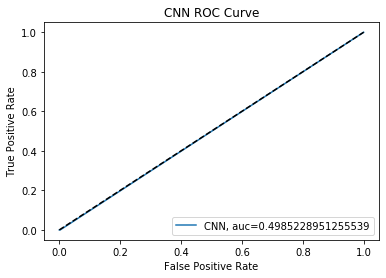

In [54]:
X_testC = X_test.reshape((X_test.shape[0], n_steps, n_length, n_signals))
y_pred_proba = model.predict(X_testC) 
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="CNN, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('CNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

# Logistic Regression

In [55]:
# Load segmented features 
data = pd.read_csv(output_folder + 'derived_features_target.csv')

# data.set_index(['id_measurement'], inplace=True)
print('feature data shape : ', data.shape)

feature data shape :  (2904, 19)


In [56]:
data.head()

,id_measurement,peaks_idx_count_Quadrant02,n5_mean_Quadrant02,n25_mean_Quadrant02,n95_mean_Quadrant02,rms_mean_Quadrant02,peak_count_total,peaks_idx_count_Quadrant13,n5_mean_Quadrant13,n25_mean_Quadrant13,n95_mean_Quadrant13,rms_mean_Quadrant13,heights_mean_Quadrant02,heights_std_Quadrant02,ratio_prev_mean_Quadrant02,ratio_next_mean_Quadrant02,abs_small_dist_to_min_mean_Quadrant02,sawtooth_rmse_mean_Quadrant02,target
0,0,271,-1.596174,-0.659582,1.588798,0.776835,436,165,-1.581346,-0.649797,1.574561,0.769181,7.983080,4.080501,0.424796,0.514141,1.468635,0.080991,0.0
1,1,340,-1.386085,-0.551815,1.369998,0.670829,588,248,-1.357613,-0.541930,1.340048,0.656969,9.490249,6.729119,0.471552,0.527007,1.505882,0.082910,1.0
2,2,56,-2.151651,-0.919952,2.150393,1.060984,108,52,-2.095261,-0.898644,2.093513,1.034456,10.010407,8.000431,0.306741,0.342301,2.267857,0.114437,0.0
3,3,355,-2.560254,-1.043100,2.555344,1.327088,681,326,-2.678056,-1.090626,2.674392,1.356389,13.344458,10.297633,0.465003,0.465384,2.256338,0.177119,0.0
4,4,241,-1.203687,-0.474672,1.192867,0.585568,470,229,-1.196896,-0.474770,1.187922,0.582965,9.013245,8.514853,0.435026,0.457522,2.199170,0.089538,0.0


In [57]:
data.fillna(0, inplace=True)

In [58]:
#splitting train_test_split

X = data.drop(['id_measurement', 'target'], axis=1)
y = data['target'].astype(bool)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=RANDOM_STATE, stratify=y)

In [59]:
# Creating  LOGISTIC Regression  model before hyper parameter tunning parameter
logreg = LogisticRegression(solver='lbfgs', multi_class='auto', C=0.01).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

C:\Users\Mukund\.conda\envs\issmCA3VSB\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training set score: 0.947
Test set score: 0.932


In [60]:
# Predicting  LOGISTIC Regression  model before hyper parameter tunning parameter
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[891  12]
 [ 54  11]]
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       903
        True       0.48      0.17      0.25        65

    accuracy                           0.93       968
   macro avg       0.71      0.58      0.61       968
weighted avg       0.91      0.93      0.92       968



### Plotting the ROC curve and AUC

Accuracy= 0.9318181818181818


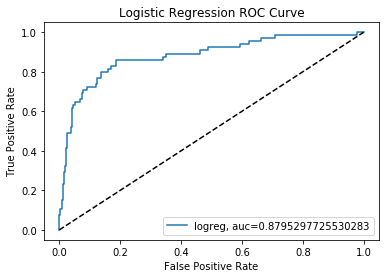

In [61]:
print("Accuracy=", metrics.accuracy_score(y_test, y_pred))
 
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="logreg, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [62]:
%%time
#Apply the RandomizedSearchCV to tune hyperparameter for  L1 Regularization (Lasso Regression )
#Lasso Regression (Least Absolute Shrinkage and Selection Operator) 
#adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

#Apply the RandomizedSearchCV to tune hyperparameter for  L2 Regularization (Ridge regression )
#Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. 
# L2 - RandomizedSearchCV allows Dual or primal formulation. 
#Dual formulation is only implemented for l2 penalty. Prefer dual=False when n_samples > n_features.
#Since n_samples > n_features, keeping the dual as "False"

#Using RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
import time

lr = LogisticRegression(solver = 'liblinear')
param_dist_p={"max_iter": [100,110], "dual": [False],  "C": [0.5,1.0,1.5], "penalty": ["l1","l2"]}
                
       
scores = ['precision', 'recall', 'roc_auc', 'accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" %score)
    
    clf  = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_p, cv = 5, n_jobs=-1,scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Randomsearch scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    
    y_pred_proba = logreg.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f'AUC ROC for test set is {auc:0.4f}')



# Tuning hyper-parameters for precision
Best parameters set found on development set:

{'penalty': 'l1', 'max_iter': 100, 'dual': False, 'C': 1.5}

Randomsearch scores on development set:

0.859 (+/-0.177) for {'penalty': 'l2', 'max_iter': 110, 'dual': False, 'C': 0.5}
0.840 (+/-0.196) for {'penalty': 'l1', 'max_iter': 100, 'dual': False, 'C': 0.5}
0.852 (+/-0.183) for {'penalty': 'l2', 'max_iter': 110, 'dual': False, 'C': 1.0}
0.884 (+/-0.144) for {'penalty': 'l1', 'max_iter': 110, 'dual': False, 'C': 1.5}
0.858 (+/-0.178) for {'penalty': 'l2', 'max_iter': 110, 'dual': False, 'C': 1.5}
0.858 (+/-0.178) for {'penalty': 'l2', 'max_iter': 100, 'dual': False, 'C': 1.5}
0.852 (+/-0.183) for {'penalty': 'l2', 'max_iter': 100, 'dual': False, 'C': 1.0}
0.875 (+/-0.153) for {'penalty': 'l1', 'max_iter': 100, 'dual': False, 'C': 1.0}
0.886 (+/-0.141) for {'penalty': 'l1', 'max_iter': 100, 'dual': False, 'C': 1.5}
0.876 (+/-0.155) for {'penalty': 'l1', 'max_iter': 110, 'dual': False, 'C': 1.0}



In [63]:
# On seeing the above results from the RansomisedSearchCV hyper tunning the parameter for roc-auc scoring, voted the following parameter as the best

#{'penalty': 'l1', 'max_iter': 110, 'dual': False, 'C': 0.5}

#Hence using the parameter generating the model.
logreg = LogisticRegression(C=0.5, penalty='l1',max_iter=110).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))


C:\Users\Mukund\.conda\envs\issmCA3VSB\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.961
Test set score: 0.940


In [64]:
# Predicting  LOGISTIC Regression  model after hyper parameter tunning parameter
y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[886  17]
 [ 41  24]]
              precision    recall  f1-score   support

       False       0.96      0.98      0.97       903
        True       0.59      0.37      0.45        65

    accuracy                           0.94       968
   macro avg       0.77      0.68      0.71       968
weighted avg       0.93      0.94      0.93       968



In [65]:
y_pred_probas = logreg.predict_proba(X_test)

Accuracy= 0.9400826446280992


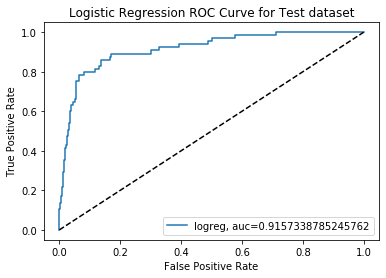

In [66]:
print("Accuracy=", metrics.accuracy_score(y_test, y_pred))
 
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="logreg, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('Logistic Regression ROC Curve for Test dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

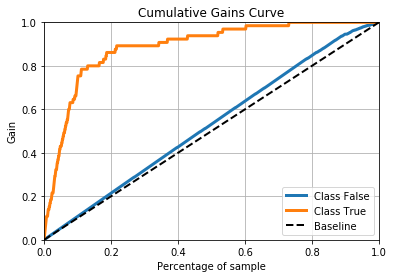

In [67]:
skplt.metrics.plot_cumulative_gain(y_test, y_pred_probas)
plt.show()

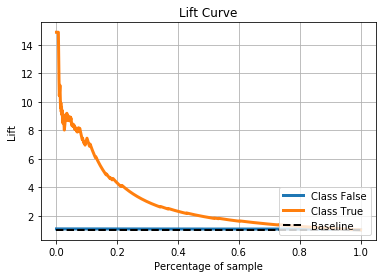

In [68]:
skplt.metrics.plot_lift_curve(y_test, y_pred_probas)
plt.show()

# Random Forest

In [69]:
# Random Forest Classifier
random_state = 1
class_weight = dict({0:0.5, 1:2.0})



RF_classifier = RandomForestClassifier(bootstrap=True, class_weight=class_weight, criterion='gini',
                                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=10,
                                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                                       oob_score=False, random_state=random_state, verbose=0, warm_start=False)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))  

[[882  21]
 [ 25  40]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       903
        True       0.66      0.62      0.63        65

    accuracy                           0.95       968
   macro avg       0.81      0.80      0.80       968
weighted avg       0.95      0.95      0.95       968

0.9524793388429752


### Plotting the ROC curve and AUC

AUC score of Test data set based on predict is : 0.7961
AUC Score of Test data set based on predict_proba for RandomForest is 0.9500 


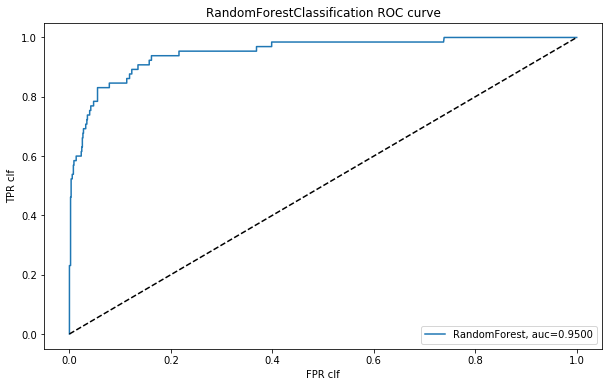

In [71]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_pred = RF_classifier.predict(X_test)
fprclf, tprclf, thresholdsclf = roc_curve(y_test, y_pred)
roc_auc = auc(fprclf, tprclf)
print(f'AUC score of Test data set based on predict is : {roc_auc:0.4f}')

y_prob = RF_classifier.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
fprclf, tprclf, thresholdsclf = roc_curve(y_test, y_prob)
roc_auc = auc(fprclf, tprclf)

print (f'AUC Score of Test data set based on predict_proba for RandomForest is {roc_auc:0.4f} ')

plt.gcf().set_size_inches(10,6)
plt.clf()
plt.plot(fprclf, tprclf, label="RandomForest, auc="+f"{roc_auc:0.4f}")
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.xlabel('FPR clf')
plt.ylabel('TPR clf')
plt.title('RandomForestClassification ROC curve')
plt.show()

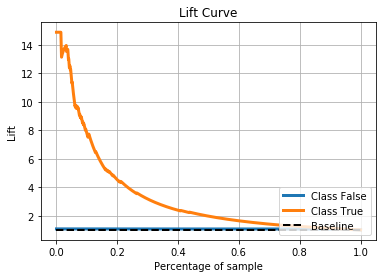

In [72]:

y_pred_probas = RF_classifier.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test, y_pred_probas)
plt.show()

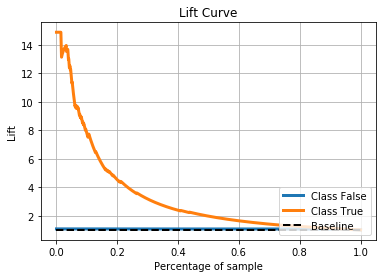

In [73]:

skplt.metrics.plot_lift_curve(y_test, y_pred_probas)
plt.show()

In [75]:
print('Execution Duration: {}'.format(datetime.now() - start_time))

Execution Duration: 0:44:51.218818


In [189]:
# @numba.jit
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        #print("i",i)
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        covar = std / mean
        asymmetry = mean - percentil_calc[4]
        new_ts.append(np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc]))
    return np.asarray(new_ts)

In [190]:
# @numba.jit
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]


In [191]:
# @numba.jit
def prep_data(start, end, df_train):
    # signal_ids = [str(i) for i in range(start, end)]
    # signal_train = parq_data[signal_ids]
    X = []
    y = []
    i=0
    #for id_measurement in tqdm(df_train.index.levels[0].unique()):
    # mids = df_meta.loc[df_meta.signal_id.isin(signal_ids), "id_measurement"].unique().tolist()
    
    # for id_measurement in tqdm(mids) :

    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        i = i+1
        X_signal = []
        for phase in [0,1,2]:
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            #print(signal_id)
            if phase == 0:
                y.append(target)
                #print("appending target",i)
                
            X_signal.append(transform_ts(parq_data[str(signal_id)]))
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y


In [192]:
%xmode

Exception reporting mode: Verbose


In [193]:
s_start, s_end = 0, 8712

%%time

# Extract features for Deep learning model analysis of Signal data

max_num = 127
min_num = -128

df_train = df_meta.copy()
df_train = df_train.set_index(['id_measurement', 'phase'])
X, y = prep_data(s_start, s_end, df_train)   # Prepare Features for Deep learning models
X = np.concatenate(X)

In [195]:
%%time

max_num = 127
min_num = -128

X = []
y = []

df_train = df_meta.copy()
df_train = df_train.set_index(['id_measurement', 'phase'])

def load_all():
    total_size = len(df_train[s_start : s_end])
    #print("total_size",total_size)
    #total_size =48
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        #print("ini",ini)
        #print("end",end)
        X_temp, y_temp = prep_data(ini, end, df_train)
        X.append(X_temp)
        y.append(y_temp)

load_all()
X = np.concatenate(X)
y = np.concatenate(y)


Wall time: 18min 49s


In [196]:
print('X.shape ', X.shape)
print('y.shape', y.shape)
print('train label y[:2]', y[:2])

X.shape  (2904, 160, 39)
y.shape (2904,)
train label y[:2] [0 1]


In [197]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=RANDOM_STATE, stratify=y)

In [198]:
opt = 'RMSprop'
def createCNNModel():
   
    inputs= Input((160,39))
    x = Conv1D(48, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(64, 3,padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    
    x = Conv1D(128, 3,padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    '''
    x = Conv1D(256, 3,padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    '''
    
    x = Flatten()(x)
    x = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs,outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model
                           # Setup the models
model       = createCNNModel() # This is meant for training
modelGo     = createCNNModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 160, 39)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 160, 48)           5664      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 80, 48)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 80, 48)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 80, 64)            9280      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 40, 64)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 40, 64)            0         
__________

In [199]:
modelname= output_folder + "POWERLINE_FAULT_DETECT_CNN"
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_acc', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

                            # Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]



 # Fit the model     # This is where the training starts
model.fit(X_train, 
          y_train, 
          validation_data=(X_test, y_test), 
          epochs=40, 
          batch_size=128,
          shuffle=True,
          callbacks=callbacks_list)

# Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do  # final evaluation on it
        
modelGo.load_weights(filepath)
modelGo.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
 

Train on 1936 samples, validate on 968 samples
Epoch 1/40
1936/1936 [==============================] - ETA: 26s - loss: 4.7680 - acc: 0.85 - ETA: 3s - loss: 4.2446 - acc: 0.9047 - ETA: 1s - loss: 3.8307 - acc: 0.923 - ETA: 0s - loss: 3.5917 - acc: 0.931 - 3s 1ms/step - loss: 3.4136 - acc: 0.9329 - val_loss: 2.4375 - val_acc: 0.9390
Epoch 2/40
1936/1936 [==============================] - ETA: 0s - loss: 2.6431 - acc: 0.890 - ETA: 0s - loss: 2.3312 - acc: 0.932 - ETA: 0s - loss: 2.1594 - acc: 0.942 - ETA: 0s - loss: 2.1010 - acc: 0.938 - 0s 143us/step - loss: 2.0551 - acc: 0.9385 - val_loss: 1.6270 - val_acc: 0.9390
Epoch 3/40
1936/1936 [==============================] - ETA: 0s - loss: 1.5977 - acc: 0.937 - ETA: 0s - loss: 1.5453 - acc: 0.940 - ETA: 0s - loss: 1.4981 - acc: 0.931 - ETA: 0s - loss: 1.4363 - acc: 0.936 - 0s 161us/step - loss: 1.3861 - acc: 0.9380 - val_loss: 1.1510 - val_acc: 0.9349
Epoch 4/40
1936/1936 [==============================] - ETA: 0s - loss: 1.0340 - acc: 0.96

Epoch 29/40
1936/1936 [==============================] - ETA: 0s - loss: 0.1368 - acc: 0.953 - ETA: 0s - loss: 0.1447 - acc: 0.946 - ETA: 0s - loss: 0.1278 - acc: 0.959 - ETA: 0s - loss: 0.1257 - acc: 0.960 - ETA: 0s - loss: 0.1345 - acc: 0.957 - 0s 189us/step - loss: 0.1346 - acc: 0.9571 - val_loss: 0.1809 - val_acc: 0.9494
Epoch 30/40
1936/1936 [==============================] - ETA: 0s - loss: 0.1175 - acc: 0.968 - ETA: 0s - loss: 0.1613 - acc: 0.948 - ETA: 0s - loss: 0.1467 - acc: 0.954 - ETA: 0s - loss: 0.1271 - acc: 0.961 - 0s 152us/step - loss: 0.1274 - acc: 0.9592 - val_loss: 0.1869 - val_acc: 0.9556
Epoch 31/40
1936/1936 [==============================] - ETA: 0s - loss: 0.0995 - acc: 0.968 - ETA: 0s - loss: 0.1070 - acc: 0.964 - ETA: 0s - loss: 0.1340 - acc: 0.960 - ETA: 0s - loss: 0.1281 - acc: 0.960 - ETA: 0s - loss: 0.1268 - acc: 0.958 - 0s 167us/step - loss: 0.1263 - acc: 0.9587 - val_loss: 0.1877 - val_acc: 0.9525
Epoch 32/40
1936/1936 [==============================] - 

In [200]:
predicts    = modelGo.predict(X_test)

labelname   = ['no','yes']
                                            # the labels for the classfication report

testScores  = metrics.accuracy_score(y_test,predicts.round())
confusion   = metrics.confusion_matrix(y_test,predicts.round())

print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(y_test,predicts.round(),target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 95.97%
              precision    recall  f1-score   support

          no     0.9647    0.9934    0.9789       909
         yes     0.8125    0.4407    0.5714        59

    accuracy                         0.9597       968
   macro avg     0.8886    0.7170    0.7751       968
weighted avg     0.9555    0.9597    0.9540       968

[[903   6]
 [ 33  26]]


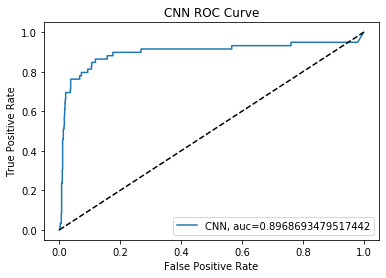

In [201]:
y_pred_proba = model.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="CNN, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('CNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## RNN - LSTM 

In [202]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [203]:
# This is NN LSTM Model creation
def define_lstm_model(input_shape):
    # The shape should be 3-dimensional
    inp = Input(shape=(input_shape[1], input_shape[2]))

    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs=inp, outputs=x)
    # addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    print (model.summary())
    
    return model

In [204]:
%%time
# Training LSTM model

N_SPLITS = 5
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE).split(X_train, y_train))
preds_val = []
y_val = []
# Trining for each fold
for idx, (train_idx, val_idx) in tqdm(enumerate(splits)):
    K.clear_session() # clears the session
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    # instantiate the model for this fold
    model = define_lstm_model(train_X.shape)
    # This checkpoint helps to avoid overfitting. It just save the weights of the model if it delivered an
    # validation matthews_correlation greater than the last one.
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, 
                           #monitor='val_roc_auc', mode='max')
                           monitor='val_matthews_correlation', mode='max')
    # Train, train, train
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt], verbose=True)
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    # and the val true y
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 39)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160, 256)          173056    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 160, 128)          164864    
_________________________________________________________________
attention_1 (Attention)      (None, 128)               288       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 346,529
Trainable params: 346,529
Non-trainable params: 0
_____________________________________________________

1548/1548 [==============================] - ETA: 0s - loss: 0.2158 - matthews_correlation: 0.22 - ETA: 0s - loss: 0.1601 - matthews_correlation: 0.39 - ETA: 0s - loss: 0.1756 - matthews_correlation: 0.38 - ETA: 0s - loss: 0.1988 - matthews_correlation: 0.35 - ETA: 0s - loss: 0.1882 - matthews_correlation: 0.37 - ETA: 0s - loss: 0.1952 - matthews_correlation: 0.35 - ETA: 0s - loss: 0.1931 - matthews_correlation: 0.29 - ETA: 0s - loss: 0.2014 - matthews_correlation: 0.30 - ETA: 0s - loss: 0.2060 - matthews_correlation: 0.32 - ETA: 0s - loss: 0.2009 - matthews_correlation: 0.33 - ETA: 0s - loss: 0.2005 - matthews_correlation: 0.34 - ETA: 0s - loss: 0.2000 - matthews_correlation: 0.33 - 1s 519us/step - loss: 0.2003 - matthews_correlation: 0.3296 - val_loss: 0.1875 - val_matthews_correlation: 0.3070

Epoch 00008: val_matthews_correlation did not improve from 0.30699
Epoch 9/50
1548/1548 [==============================] - ETA: 0s - loss: 0.2136 - matthews_correlation: 0.26 - ETA: 0s - loss:

Epoch 00016: val_matthews_correlation did not improve from 0.57357
Epoch 17/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0743 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0966 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.1164 - matthews_correlation: 0.66 - ETA: 0s - loss: 0.1306 - matthews_correlation: 0.60 - ETA: 0s - loss: 0.1211 - matthews_correlation: 0.61 - ETA: 0s - loss: 0.1144 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1245 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1270 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1245 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1194 - matthews_correlation: 0.66 - ETA: 0s - loss: 0.1171 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1205 - matthews_correlation: 0.67 - 1s 526us/step - loss: 0.1212 - matthews_correlation: 0.6712 - val_loss: 0.1202 - val_matthews_correlation: 0.6408

Epoch 00017: val_matthews_correlation improved from 0.57357 to 0.64077, saving model to weights_0.h5
Epoch 18/50


1548/1548 [==============================] - ETA: 0s - loss: 0.1513 - matthews_correlation: 0.61 - ETA: 0s - loss: 0.1342 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.1340 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1321 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1271 - matthews_correlation: 0.62 - ETA: 0s - loss: 0.1184 - matthews_correlation: 0.63 - ETA: 0s - loss: 0.1091 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1066 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1068 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.0998 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0993 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0981 - matthews_correlation: 0.68 - 1s 510us/step - loss: 0.0990 - matthews_correlation: 0.6803 - val_loss: 0.0939 - val_matthews_correlation: 0.7250

Epoch 00026: val_matthews_correlation improved from 0.72449 to 0.72498, saving model to weights_0.h5
Epoch 27/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0704 - matthews_

1548/1548 [==============================] - ETA: 0s - loss: 0.0978 - matthews_correlation: 0.77 - ETA: 0s - loss: 0.0845 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.0866 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0737 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0737 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0809 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0846 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0844 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0842 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0836 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0824 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0799 - matthews_correlation: 0.75 - 1s 517us/step - loss: 0.0794 - matthews_correlation: 0.7579 - val_loss: 0.1073 - val_matthews_correlation: 0.6830

Epoch 00035: val_matthews_correlation did not improve from 0.73899
Epoch 36/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0596 - matthews_correlation: 0.87 - ETA: 0s - loss

1548/1548 [==============================] - ETA: 0s - loss: 0.0435 - matthews_correlation: 0.90 - ETA: 0s - loss: 0.0585 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0875 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0729 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0678 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0656 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0680 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0683 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0659 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0663 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0624 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0667 - matthews_correlation: 0.81 - 1s 512us/step - loss: 0.0662 - matthews_correlation: 0.8043 - val_loss: 0.1263 - val_matthews_correlation: 0.6190

Epoch 00044: val_matthews_correlation did not improve from 0.75802
Epoch 45/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0547 - matthews_correlation: 0.88 - ETA: 0s - loss


Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_1.h5
Epoch 2/50
1548/1548 [==============================] - ETA: 0s - loss: 0.3288 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2602 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2756 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2868 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2843 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2659 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2700 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2768 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2682 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2674 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2679 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2589 - matthews_correlation: 0.0000e+ - 1s 509us/step - loss: 0.2575 - matthews_correlation: 0.0000e+00 - val_loss: 0.2349 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_

1548/1548 [==============================] - ETA: 0s - loss: 0.1593 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.1547 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1523 - matthews_correlation: 0.56 - ETA: 0s - loss: 0.1578 - matthews_correlation: 0.55 - ETA: 0s - loss: 0.1484 - matthews_correlation: 0.57 - ETA: 0s - loss: 0.1656 - matthews_correlation: 0.53 - ETA: 0s - loss: 0.1604 - matthews_correlation: 0.55 - ETA: 0s - loss: 0.1485 - matthews_correlation: 0.54 - ETA: 0s - loss: 0.1553 - matthews_correlation: 0.50 - ETA: 0s - loss: 0.1505 - matthews_correlation: 0.50 - ETA: 0s - loss: 0.1522 - matthews_correlation: 0.51 - ETA: 0s - loss: 0.1515 - matthews_correlation: 0.48 - 1s 506us/step - loss: 0.1508 - matthews_correlation: 0.4763 - val_loss: 0.1606 - val_matthews_correlation: 0.2060

Epoch 00010: val_matthews_correlation did not improve from 0.32225
Epoch 11/50
1548/1548 [==============================] - ETA: 0s - loss: 0.1345 - matthews_correlation: 0.62 - ETA: 0s - loss

1548/1548 [==============================] - ETA: 0s - loss: 0.1237 - matthews_correlation: 0.56 - ETA: 0s - loss: 0.0962 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0811 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0854 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0876 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0908 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0930 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0886 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0914 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0924 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0935 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0963 - matthews_correlation: 0.70 - 1s 514us/step - loss: 0.0973 - matthews_correlation: 0.6987 - val_loss: 0.1687 - val_matthews_correlation: 0.5524

Epoch 00019: val_matthews_correlation did not improve from 0.57658
Epoch 20/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0643 - matthews_correlation: 0.80 - ETA: 0s - loss

1548/1548 [==============================] - ETA: 0s - loss: 0.0821 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0768 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0775 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0802 - matthews_correlation: 0.77 - ETA: 0s - loss: 0.0722 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0723 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0756 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0749 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0767 - matthews_correlation: 0.77 - ETA: 0s - loss: 0.0751 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0773 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0796 - matthews_correlation: 0.75 - 1s 510us/step - loss: 0.0794 - matthews_correlation: 0.7544 - val_loss: 0.1567 - val_matthews_correlation: 0.6274

Epoch 00028: val_matthews_correlation did not improve from 0.63978
Epoch 29/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0733 - matthews_correlation: 0.42 - ETA: 0s - loss

1548/1548 [==============================] - ETA: 0s - loss: 0.1027 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0611 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0577 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0528 - matthews_correlation: 0.85 - ETA: 0s - loss: 0.0661 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0698 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0689 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0693 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0695 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0744 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0754 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0731 - matthews_correlation: 0.75 - 1s 510us/step - loss: 0.0726 - matthews_correlation: 0.7524 - val_loss: 0.1789 - val_matthews_correlation: 0.5387

Epoch 00037: val_matthews_correlation did not improve from 0.67819
Epoch 38/50
1548/1548 [==============================] - ETA: 0s - loss: 0.1349 - matthews_correlation: 0.66 - ETA: 0s - loss

1548/1548 [==============================] - ETA: 0s - loss: 0.1018 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.1080 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1070 - matthews_correlation: 0.63 - ETA: 0s - loss: 0.1119 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1139 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1061 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1052 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.1000 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0947 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0964 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0929 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0886 - matthews_correlation: 0.71 - 1s 545us/step - loss: 0.0879 - matthews_correlation: 0.7122 - val_loss: 0.1429 - val_matthews_correlation: 0.6401

Epoch 00046: val_matthews_correlation did not improve from 0.67819
Epoch 47/50
1548/1548 [==============================] - ETA: 0s - loss: 0.0297 - matthews_correlation: 1.00 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.2707 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2392 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2424 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2569 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2633 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2603 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2621 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2575 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2466 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2443 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2404 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2417 - matthews_correlation: 0.0000e+ - 1s 536us/step - loss: 0.2411 - matthews_correlation: 0.0000e+00 - val_loss: 0.2149 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
1549/1549 [==============================] - ETA: 0s - los

Epoch 12/50
1549/1549 [==============================] - ETA: 0s - loss: 0.2879 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.3121 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2426 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2292 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2216 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2084 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2108 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2123 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2077 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2008 - matthews_correlation: 0.0494   - ETA: 0s - loss: 0.1958 - matthews_correlation: 0.04 - ETA: 0s - loss: 0.1904 - matthews_correlation: 0.06 - 1s 531us/step - loss: 0.1893 - matthews_correlation: 0.0668 - val_loss: 0.1619 - val_matthews_correlation: 0.3216

Epoch 00012: val_matthews_correlation did not improve from 0.54973
Epoch 13/50
1549/1549 [==============================] - ETA: 0s - loss: 

1549/1549 [==============================] - ETA: 0s - loss: 0.1300 - matthews_correlation: 0.47 - ETA: 0s - loss: 0.1184 - matthews_correlation: 0.65 - ETA: 0s - loss: 0.0957 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0936 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0887 - matthews_correlation: 0.77 - ETA: 0s - loss: 0.0919 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0912 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0900 - matthews_correlation: 0.77 - ETA: 0s - loss: 0.0890 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0957 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0981 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0986 - matthews_correlation: 0.72 - 1s 553us/step - loss: 0.0979 - matthews_correlation: 0.7282 - val_loss: 0.1438 - val_matthews_correlation: 0.5934

Epoch 00021: val_matthews_correlation did not improve from 0.65185
Epoch 22/50
1549/1549 [==============================] - ETA: 0s - loss: 0.0468 - matthews_correlation: 0.74 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.0474 - matthews_correlation: 0.88 - ETA: 0s - loss: 0.0778 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0706 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0669 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0618 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0616 - matthews_correlation: 0.84 - ETA: 0s - loss: 0.0581 - matthews_correlation: 0.84 - ETA: 0s - loss: 0.0629 - matthews_correlation: 0.84 - ETA: 0s - loss: 0.0651 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0639 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0704 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0701 - matthews_correlation: 0.80 - 1s 537us/step - loss: 0.0697 - matthews_correlation: 0.8068 - val_loss: 0.1595 - val_matthews_correlation: 0.5766

Epoch 00030: val_matthews_correlation did not improve from 0.71174
Epoch 31/50
1549/1549 [==============================] - ETA: 0s - loss: 0.0569 - matthews_correlation: 0.80 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.0286 - matthews_correlation: 0.87 - ETA: 0s - loss: 0.0661 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0865 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0826 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0866 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0996 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0966 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0917 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0933 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0965 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0969 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0978 - matthews_correlation: 0.72 - 1s 562us/step - loss: 0.0970 - matthews_correlation: 0.7230 - val_loss: 0.1288 - val_matthews_correlation: 0.6567

Epoch 00039: val_matthews_correlation did not improve from 0.71174
Epoch 40/50
1549/1549 [==============================] - ETA: 0s - loss: 0.0654 - matthews_correlation: 0.89 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.0905 - matthews_correlation: 0.58 - ETA: 0s - loss: 0.0668 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0757 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0649 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0612 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0613 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0566 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0537 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0542 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0595 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0580 - matthews_correlation: 0.83 - ETA: 0s - loss: 0.0563 - matthews_correlation: 0.83 - 1s 546us/step - loss: 0.0574 - matthews_correlation: 0.8351 - val_loss: 0.2556 - val_matthews_correlation: 0.5507

Epoch 00048: val_matthews_correlation did not improve from 0.71174
Epoch 49/50
1549/1549 [==============================] - ETA: 0s - loss: 0.1121 - matthews_correlation: 0.83 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.3133 - matthews_correlation: 0.25 - ETA: 0s - loss: 0.2497 - matthews_correlation: 0.23 - ETA: 0s - loss: 0.2316 - matthews_correlation: 0.23 - ETA: 0s - loss: 0.2240 - matthews_correlation: 0.17 - ETA: 0s - loss: 0.2079 - matthews_correlation: 0.21 - ETA: 0s - loss: 0.2085 - matthews_correlation: 0.23 - ETA: 0s - loss: 0.2150 - matthews_correlation: 0.19 - ETA: 0s - loss: 0.2152 - matthews_correlation: 0.22 - ETA: 0s - loss: 0.2115 - matthews_correlation: 0.24 - ETA: 0s - loss: 0.2130 - matthews_correlation: 0.26 - ETA: 0s - loss: 0.2109 - matthews_correlation: 0.25 - ETA: 0s - loss: 0.2092 - matthews_correlation: 0.25 - 1s 536us/step - loss: 0.2101 - matthews_correlation: 0.2489 - val_loss: 0.1894 - val_matthews_correlation: 0.0991

Epoch 00005: val_matthews_correlation improved from 0.00000 to 0.09911, saving model to weights_3.h5
Epoch 6/50
1549/1549 [==============================] - ETA: 0s - loss: 0.2338 - matthews_c

1549/1549 [==============================] - ETA: 0s - loss: 0.0879 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.1561 - matthews_correlation: 0.1447   - ETA: 0s - loss: 0.1568 - matthews_correlation: 0.16 - ETA: 0s - loss: 0.1465 - matthews_correlation: 0.31 - ETA: 0s - loss: 0.1408 - matthews_correlation: 0.37 - ETA: 0s - loss: 0.1466 - matthews_correlation: 0.41 - ETA: 0s - loss: 0.1481 - matthews_correlation: 0.39 - ETA: 0s - loss: 0.1423 - matthews_correlation: 0.41 - ETA: 0s - loss: 0.1489 - matthews_correlation: 0.39 - ETA: 0s - loss: 0.1549 - matthews_correlation: 0.39 - ETA: 0s - loss: 0.1511 - matthews_correlation: 0.41 - ETA: 0s - loss: 0.1522 - matthews_correlation: 0.40 - 1s 544us/step - loss: 0.1524 - matthews_correlation: 0.4022 - val_loss: 0.1464 - val_matthews_correlation: 0.3960

Epoch 00014: val_matthews_correlation did not improve from 0.48893
Epoch 15/50
1549/1549 [==============================] - ETA: 0s - loss: 0.1261 - matthews_correlation: 0.73 - ETA: 0

1549/1549 [==============================] - ETA: 0s - loss: 0.1569 - matthews_correlation: 0.63 - ETA: 0s - loss: 0.0965 - matthews_correlation: 0.66 - ETA: 0s - loss: 0.0911 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0855 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0959 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.1042 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.1086 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.1276 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1331 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1244 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.1163 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.1111 - matthews_correlation: 0.70 - 1s 557us/step - loss: 0.1105 - matthews_correlation: 0.7000 - val_loss: 0.1380 - val_matthews_correlation: 0.5068

Epoch 00023: val_matthews_correlation did not improve from 0.66247
Epoch 24/50
1549/1549 [==============================] - ETA: 0s - loss: 0.1284 - matthews_correlation: 0.76 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.1518 - matthews_correlation: 0.66 - ETA: 0s - loss: 0.1358 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.1214 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0987 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0956 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0874 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0847 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.1007 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0963 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0945 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0907 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0902 - matthews_correlation: 0.74 - 1s 541us/step - loss: 0.0938 - matthews_correlation: 0.7409 - val_loss: 0.1372 - val_matthews_correlation: 0.6027

Epoch 00032: val_matthews_correlation did not improve from 0.66247
Epoch 33/50
1549/1549 [==============================] - ETA: 0s - loss: 0.0870 - matthews_correlation: 0.65 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.1057 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0894 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0870 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0889 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0902 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0943 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0896 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0886 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0854 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0921 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0898 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0878 - matthews_correlation: 0.76 - 1s 540us/step - loss: 0.0872 - matthews_correlation: 0.7665 - val_loss: 0.1334 - val_matthews_correlation: 0.5967

Epoch 00041: val_matthews_correlation did not improve from 0.72476
Epoch 42/50
1549/1549 [==============================] - ETA: 0s - loss: 0.0719 - matthews_correlation: 0.65 - ETA: 0s - loss

1549/1549 [==============================] - ETA: 0s - loss: 0.0683 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0629 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0595 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0618 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0594 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0683 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0740 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0840 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0873 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0861 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0825 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0905 - matthews_correlation: 0.75 - 1s 560us/step - loss: 0.0898 - matthews_correlation: 0.7458 - val_loss: 0.1560 - val_matthews_correlation: 0.5698

Epoch 00050: val_matthews_correlation did not improve from 0.72476
Beginning fold 5
_________________________________________________________________
Layer (type)                 Output Shape 

1550/1550 [==============================] - ETA: 0s - loss: 0.1551 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2185 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2247 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2188 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2151 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2159 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2207 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2194 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2187 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2247 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2178 - matthews_correlation: 0.0000e+ - ETA: 0s - loss: 0.2216 - matthews_correlation: 0.0000e+ - 1s 563us/step - loss: 0.2210 - matthews_correlation: 0.0000e+00 - val_loss: 0.2568 - val_matthews_correlation: 0.0000e+00

Epoch 00007: val_matthews_correlation did not improve from 0.00000
Epoch 8/50
1550/1550 [==============================] - ETA: 0s - los


Epoch 00015: val_matthews_correlation improved from 0.50429 to 0.62181, saving model to weights_4.h5
Epoch 16/50
1550/1550 [==============================] - ETA: 0s - loss: 0.1432 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1542 - matthews_correlation: 0.56 - ETA: 0s - loss: 0.1248 - matthews_correlation: 0.56 - ETA: 0s - loss: 0.1172 - matthews_correlation: 0.53 - ETA: 0s - loss: 0.1164 - matthews_correlation: 0.52 - ETA: 0s - loss: 0.1088 - matthews_correlation: 0.43 - ETA: 0s - loss: 0.1069 - matthews_correlation: 0.46 - ETA: 0s - loss: 0.1105 - matthews_correlation: 0.46 - ETA: 0s - loss: 0.1126 - matthews_correlation: 0.47 - ETA: 0s - loss: 0.1150 - matthews_correlation: 0.48 - ETA: 0s - loss: 0.1191 - matthews_correlation: 0.48 - ETA: 0s - loss: 0.1196 - matthews_correlation: 0.50 - 1s 549us/step - loss: 0.1186 - matthews_correlation: 0.4990 - val_loss: 0.1295 - val_matthews_correlation: 0.6483

Epoch 00016: val_matthews_correlation improved from 0.62181 to 0.64829, saving

1550/1550 [==============================] - ETA: 0s - loss: 0.1500 - matthews_correlation: 0.61 - ETA: 0s - loss: 0.1611 - matthews_correlation: 0.61 - ETA: 0s - loss: 0.1330 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1248 - matthews_correlation: 0.64 - ETA: 0s - loss: 0.1105 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1181 - matthews_correlation: 0.67 - ETA: 0s - loss: 0.1054 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0942 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0953 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0922 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0934 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0931 - matthews_correlation: 0.73 - 1s 545us/step - loss: 0.0935 - matthews_correlation: 0.7275 - val_loss: 0.1077 - val_matthews_correlation: 0.7258

Epoch 00025: val_matthews_correlation improved from 0.68389 to 0.72581, saving model to weights_4.h5
Epoch 26/50
1550/1550 [==============================] - ETA: 0s - loss: 0.0748 - matthews_

1550/1550 [==============================] - ETA: 0s - loss: 0.0845 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1035 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0716 - matthews_correlation: 0.82 - ETA: 0s - loss: 0.0794 - matthews_correlation: 0.81 - ETA: 0s - loss: 0.0701 - matthews_correlation: 0.80 - ETA: 0s - loss: 0.0724 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0752 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0713 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0774 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0783 - matthews_correlation: 0.78 - ETA: 0s - loss: 0.0782 - matthews_correlation: 0.79 - ETA: 0s - loss: 0.0814 - matthews_correlation: 0.79 - 1s 544us/step - loss: 0.0809 - matthews_correlation: 0.7874 - val_loss: 0.1270 - val_matthews_correlation: 0.6592

Epoch 00034: val_matthews_correlation did not improve from 0.72581
Epoch 35/50
1550/1550 [==============================] - ETA: 0s - loss: 0.0695 - matthews_correlation: 0.58 - ETA: 0s - loss

1550/1550 [==============================] - ETA: 0s - loss: 0.1019 - matthews_correlation: 0.68 - ETA: 0s - loss: 0.1039 - matthews_correlation: 0.75 - ETA: 0s - loss: 0.0943 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0899 - matthews_correlation: 0.71 - ETA: 0s - loss: 0.0878 - matthews_correlation: 0.73 - ETA: 0s - loss: 0.0891 - matthews_correlation: 0.74 - ETA: 0s - loss: 0.0853 - matthews_correlation: 0.76 - ETA: 0s - loss: 0.0855 - matthews_correlation: 0.72 - ETA: 0s - loss: 0.0868 - matthews_correlation: 0.69 - ETA: 0s - loss: 0.0871 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0882 - matthews_correlation: 0.70 - ETA: 0s - loss: 0.0851 - matthews_correlation: 0.70 - 1s 550us/step - loss: 0.0844 - matthews_correlation: 0.7033 - val_loss: 0.1304 - val_matthews_correlation: 0.6990

Epoch 00043: val_matthews_correlation did not improve from 0.72581
Epoch 44/50
1550/1550 [==============================] - ETA: 0s - loss: 0.0533 - matthews_correlation: 0.89 - ETA: 0s - loss

((1936,), (1936,))

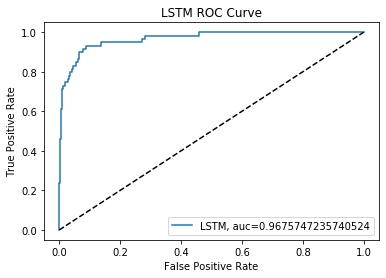

In [205]:
 
y_pred_proba = model.predict(X_test) 
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="LSTM, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.title('LSTM ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()